# Load in Data
The data is already cleaned by currently existing matchms filters

In [1]:
import os
import pickle
import numpy as np

def load_pickled_file(filename: str):
    with open(filename, 'rb') as file:
        loaded_object = pickle.load(file)
    return loaded_object

def save_pickled_file(obj, filename: str):
    assert not os.path.exists(filename), "File already exists"
    with open(filename, "wb") as f:
        pickle.dump(obj, f)

lib_dir = "../../../../../ms2deepscore/data/cleaning_spectra/"

# annotated_spectra = load_pickled_file(os.path.join(lib_dir, "annotated_spectra.pickle"))
annotated_spectra = []
mass_tolerance = 0.01


In [2]:
import matplotlib.pyplot as plt

from matchms.filtering.repair_parent_mass_from_smiles.require_parent_mass_match_smiles import _get_monoisotopic_neutral_mass

def plot_all(spectra):
    mass_differences, parent_masses, expected_masses = select_mass_differences(spectra)
    plot_ratio_mass_diff_parent_mass(parent_masses, expected_masses)
    plot_mass_difference_vs_parent_mass(parent_masses, mass_differences)
    plot_mass_difference_vs_parent_mass(parent_masses, mass_differences, zoom=True)
    plot_mass_difference(mass_differences)
    plot_mass_difference(mass_differences, (-10, 10))
    plot_mass_difference(mass_differences, (-100, 100))

def select_mass_differences(spectra):
    mass_differences = []
    parent_masses = []
    expected_masses = []
    for spectrum in tqdm(spectra):
        expected_mass = _get_monoisotopic_neutral_mass(spectrum.get("smiles"))
        parent_mass = spectrum.get("parent_mass")
        mass_difference = parent_mass-expected_mass

        mass_differences.append(mass_difference)
        parent_masses.append(parent_mass)
        expected_masses.append(expected_mass)
    return mass_differences, parent_masses, expected_masses


def plot_ratio_mass_diff_parent_mass(parent_masses,
                                     expected_masses):
    mass_ratios = []
    for i, parent_mass in enumerate(parent_masses):
        mass_ratio = parent_mass/ expected_masses[i]
        mass_ratios.append(mass_ratio)
    plt.hist(mass_ratios, bins=1000)
    plt.yscale("log")
    plt.xlabel("parent mass / smiles mass")
    plt.xlim((0,4.5))
    plt.show()

def plot_mass_difference_vs_parent_mass(parent_masses,
                                        mass_differences,
                                        zoom = False):
    plt.scatter(parent_masses, mass_differences, alpha=0.02)
    plt.xlabel("Parent mass (Da)")
    plt.ylabel("Mass difference (Da)")
    if zoom:
        plt.ylim((-3,3))
    plt.show()

def plot_mass_difference(mass_differences,
                         zoom = None):
    if zoom is not None:
        mass_differences = [mass_difference for mass_difference in mass_differences if zoom[0] < mass_difference < zoom[1]]
        # plt.xticks(np.arange(zoom[0], zoom[1], 1))
    n, bins, patches = plt.hist(mass_differences, bins=1000)
        # Find peaks in the histogram
    from scipy.signal import find_peaks
    peaks, _ = find_peaks(n, threshold=50)

    # Add labels to the highest peaks
    for peak in peaks:
        plt.text(bins[peak], n[peak], f'{bins[peak]:.1f}', ha='center', va='bottom')

    # plt.yscale("log")
    plt.xlabel("Mass difference (Da)")
    plt.show()

In [3]:
from matchms import set_matchms_logger_level
from tqdm.notebook import tqdm
from matchms.filtering.repair_parent_mass_from_smiles.require_parent_mass_match_smiles import require_parent_mass_match_smiles

set_matchms_logger_level("WARNING")
def repair_spectra(spectra, mass_tolerance, file_extension, filtering_function, **kwargs):
    save_file_name_repaired = os.path.join(lib_dir,
                                  f"repaired_{mass_tolerance}_{file_extension}.pickle")
    save_file_name_not_repaired = os.path.join(lib_dir,
                              f"not_repaired_{mass_tolerance}_{file_extension}.pickle")
    if os.path.exists(save_file_name_repaired):
        print("loaded in spectra")
        return load_pickled_file(save_file_name_not_repaired), load_pickled_file(save_file_name_repaired)

    not_repaired = []
    repaired = []
    corrected = 0
    for spectrum in tqdm(spectra):
        spectrum_out = filtering_function(spectrum, mass_tolerance=mass_tolerance,
                                                     **kwargs)
        if require_parent_mass_match_smiles(spectrum_out, mass_tolerance) is None:
            not_repaired.append(spectrum)
        else:
            repaired.append(spectrum)
            corrected += 1
    save_pickled_file(not_repaired, save_file_name_not_repaired)
    save_pickled_file(repaired, save_file_name_repaired)
    return not_repaired, repaired


# Mass tolerance = 0.01

In [4]:
mass_tolerance = 0.01
from matchms.filtering.repair_parent_mass_from_smiles.require_parent_mass_match_smiles import require_parent_mass_match_smiles

# not_repaired, repaired = repair_spectra(annotated_spectra, mass_tolerance,
#                                                "no_repair", require_parent_mass_match_smiles)
# plot_all(not_repaired)
# plot_all(repaired)
save_file_name = os.path.join(lib_dir,
                              f"spectra_not_in_{mass_tolerance}.pickle")
not_repaired = load_pickled_file(save_file_name)

loaded in spectra


  0%|          | 0/36100 [00:00<?, ?it/s]

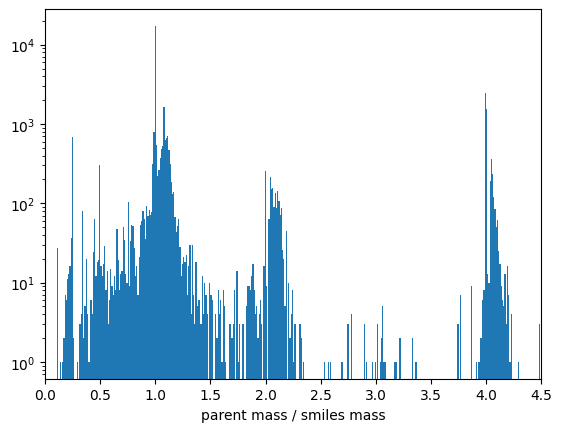

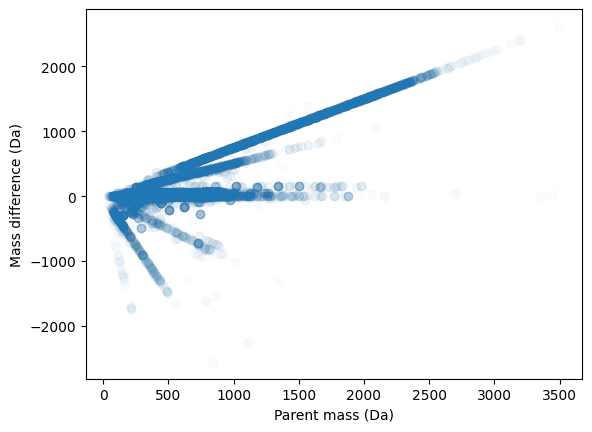

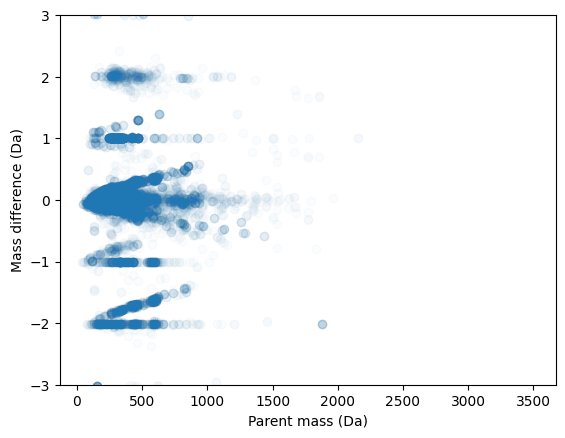

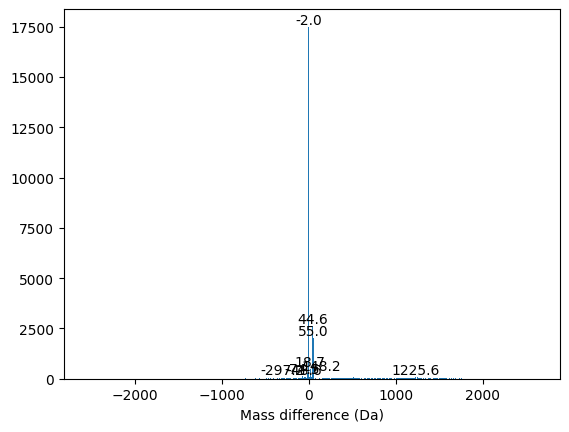

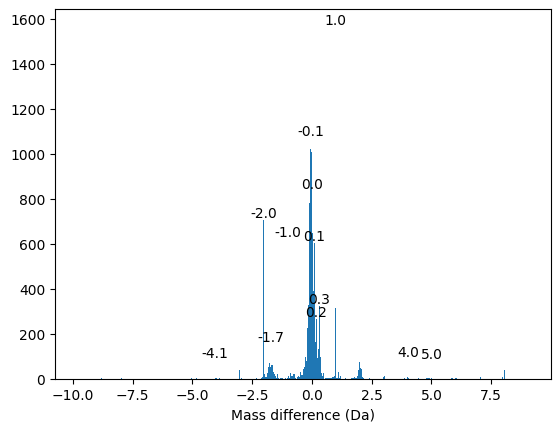

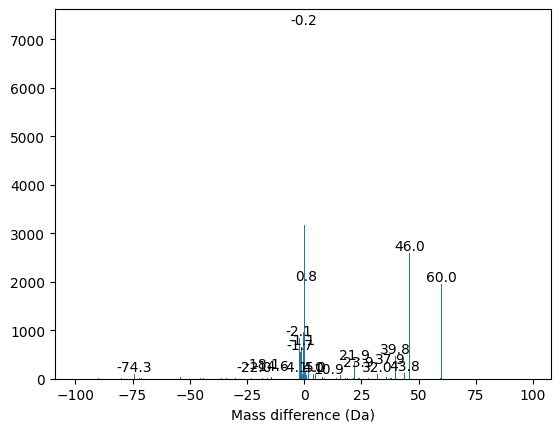

  0%|          | 0/1352 [00:00<?, ?it/s]

[11:16:07] WARNING: not removing hydrogen atom without neighbors


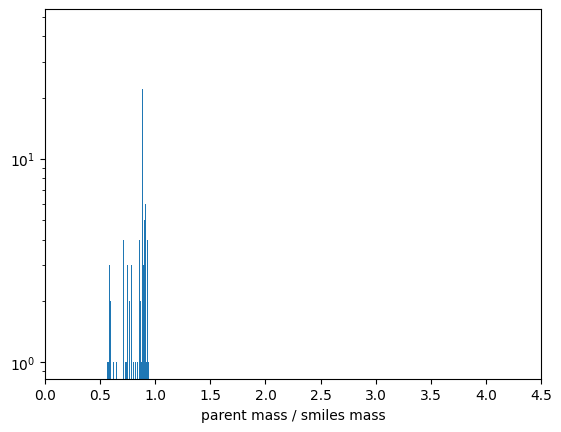

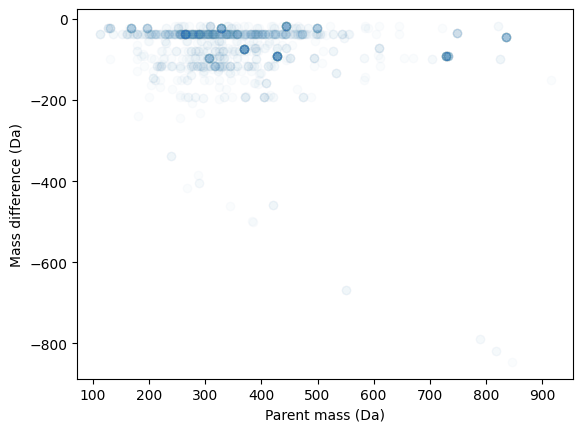

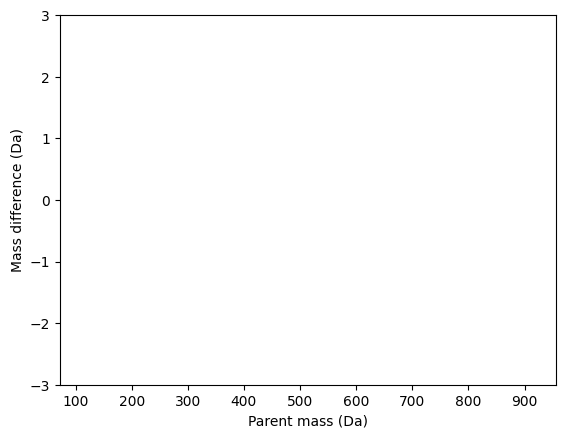

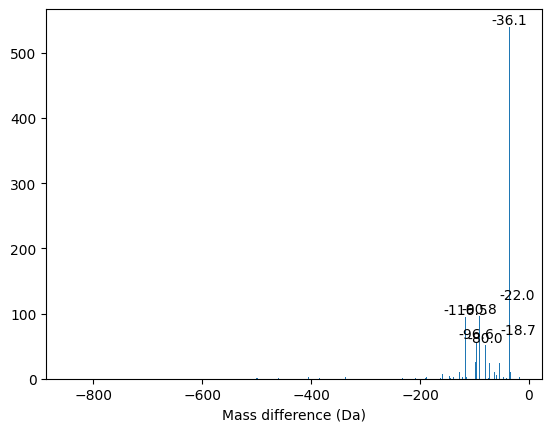

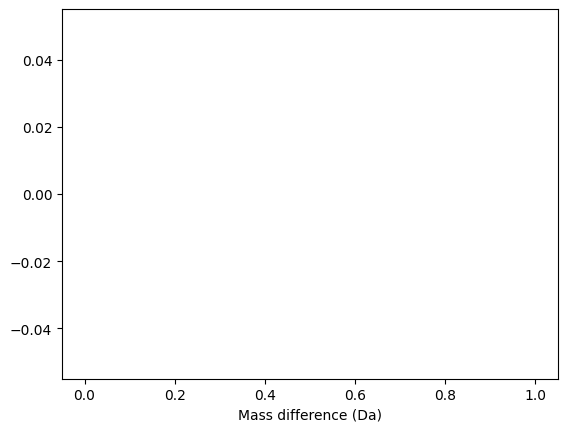

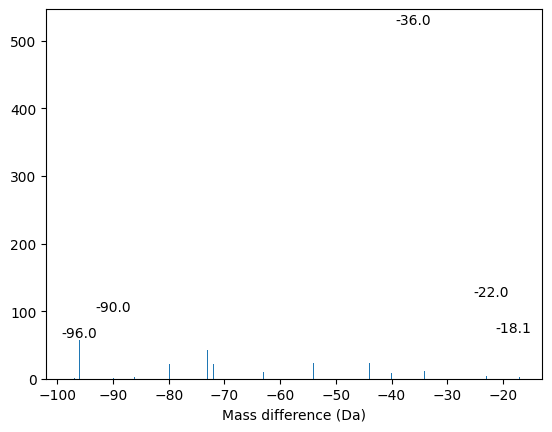

In [6]:
from matchms.filtering.repair_parent_mass_from_smiles.repair_smiles_salt_ions import repair_smiles_salt_ions

not_repaired, repaired = repair_spectra(not_repaired, mass_tolerance, "smiles_salt_ions", repair_smiles_salt_ions)
plot_all(not_repaired)
plot_all(repaired)

  0%|          | 0/37452 [00:00<?, ?it/s]

[17:40:19] WARNING: not removing hydrogen atom without neighbors
[17:40:19] WARNING: not removing hydrogen atom without neighbors
[17:40:19] WARNING: not removing hydrogen atom without neighbors


  0%|          | 0/36875 [00:00<?, ?it/s]

[17:41:34] WARNING: not removing hydrogen atom without neighbors


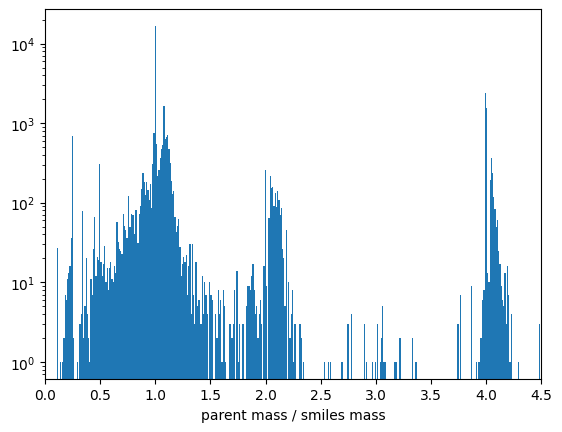

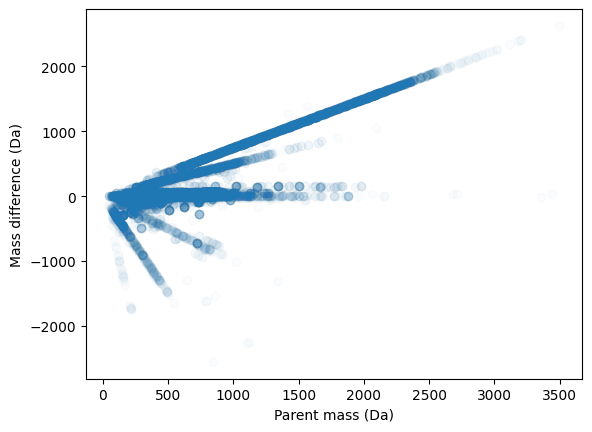

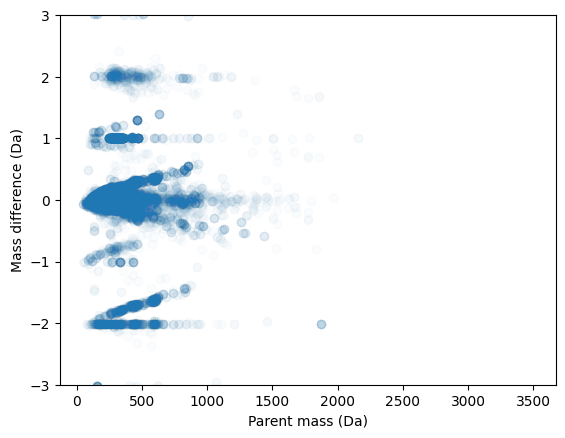

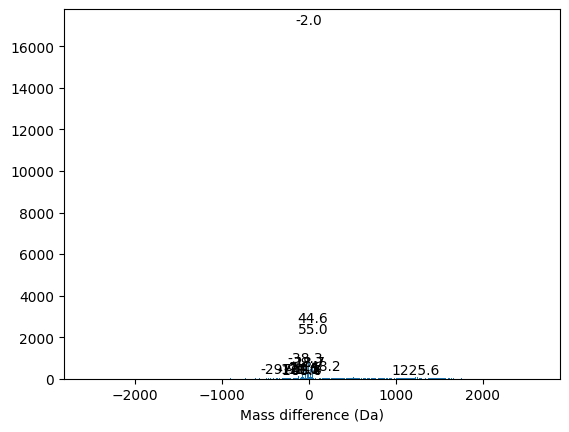

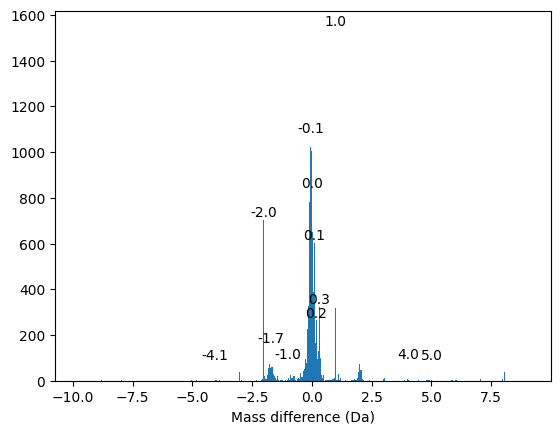

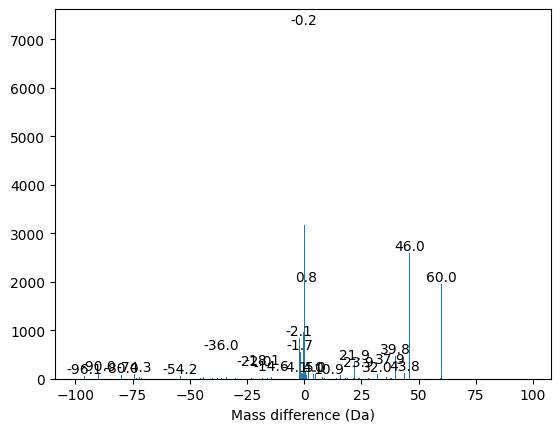

  0%|          | 0/577 [00:00<?, ?it/s]

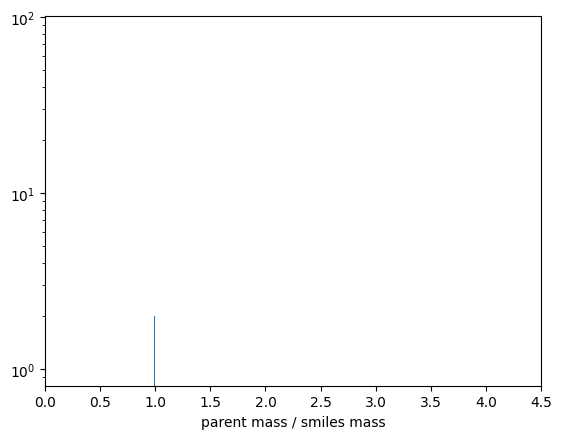

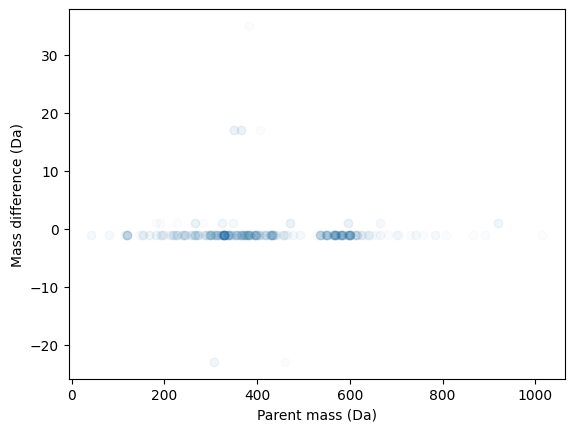

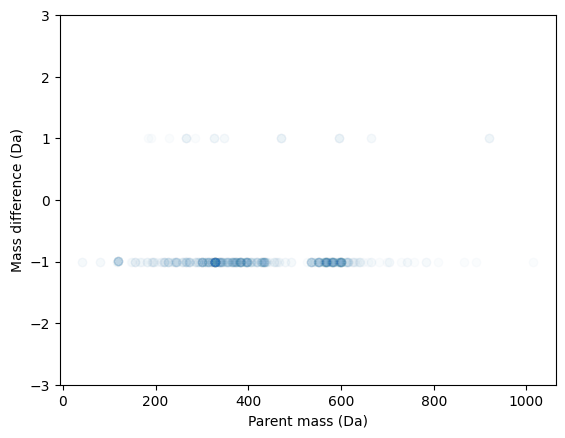

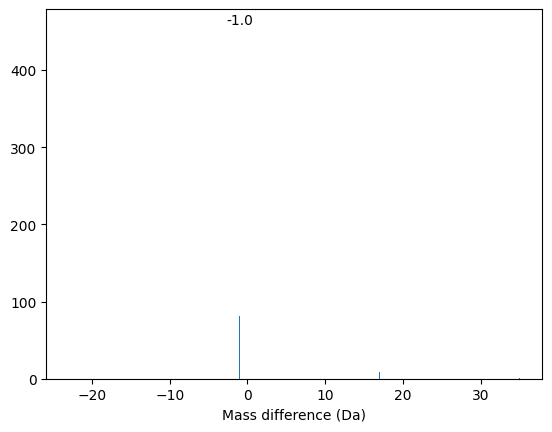

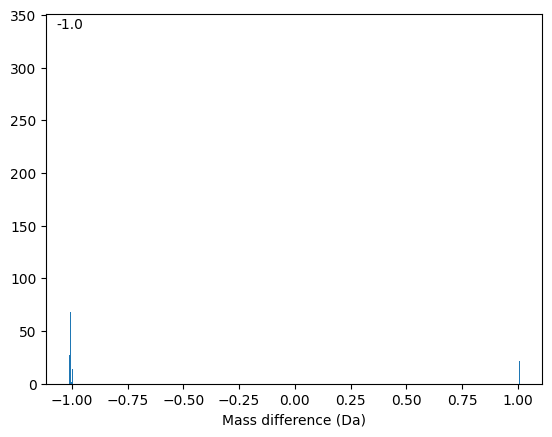

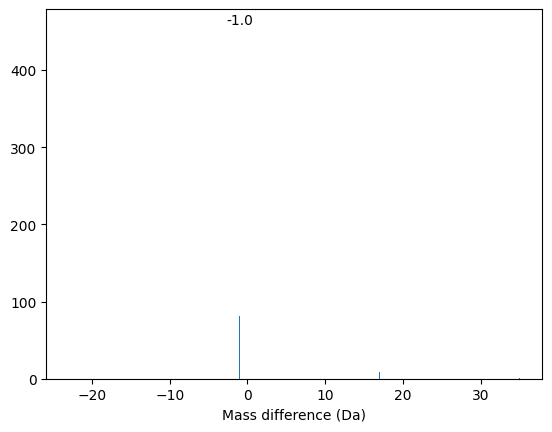

In [6]:
from matchms.filtering.repair_parent_mass_from_smiles.repair_precursor_is_parent_mass import repair_precursor_is_parent_mass

not_repaired, repaired = repair_spectra(not_repaired, mass_tolerance,
                                        "precursor_is_parent_mass",
                                        repair_precursor_is_parent_mass)
plot_all(not_repaired)
plot_all(repaired)

In [5]:
from matchms.filtering.repair_parent_mass_from_smiles.repair_parent_mass_is_mol_wt import repair_parent_mass_is_mol_wt

not_repaired, repaired = repair_spectra(not_repaired, mass_tolerance,
                                        "parent_mass_is_mol_wt", repair_parent_mass_is_mol_wt)
# plot_all(not_repaired)
# plot_all(repaired)


loaded in spectra


  0%|          | 0/36065 [00:00<?, ?it/s]

[11:22:00] WARNING: not removing hydrogen atom without neighbors
[11:22:00] WARNING: not removing hydrogen atom without neighbors


2023-06-19 11:23:14,309:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 11:23:14,343:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 11:23:15,588:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 11:23:15,588:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 11:23:15,603:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 11:23:15,603:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 11:23:15,603:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 11:23:15,619:WARNING:matchms:repair_adduct_based_on

  0%|          | 0/22406 [00:00<?, ?it/s]

[11:23:43] WARNING: not removing hydrogen atom without neighbors


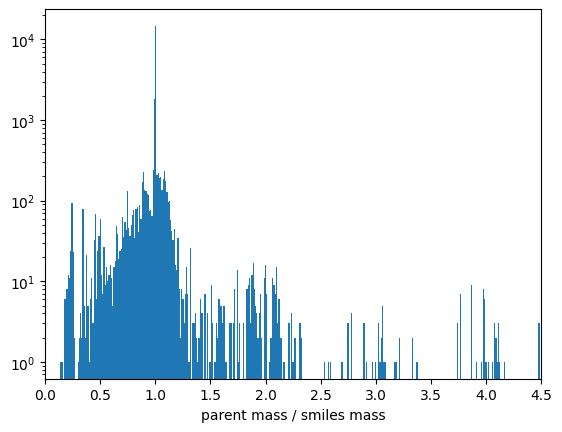

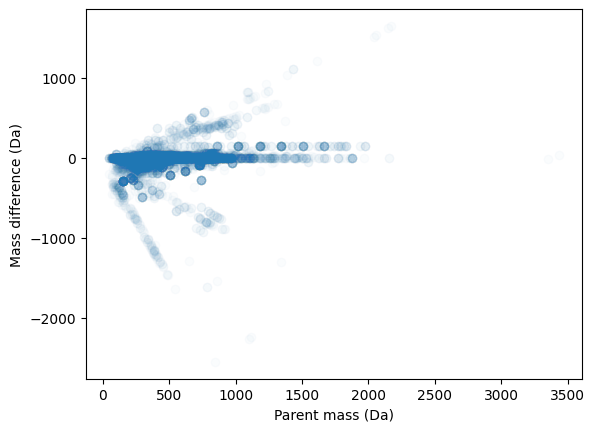

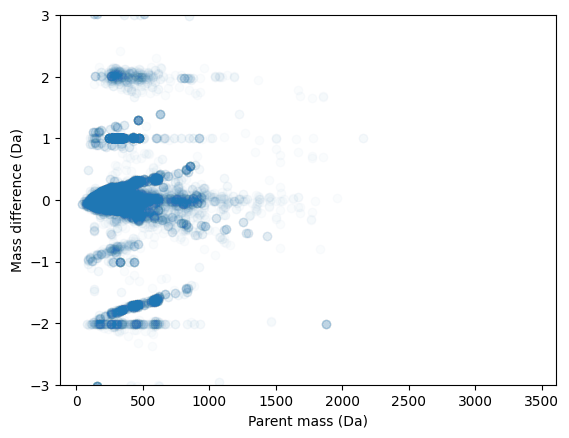

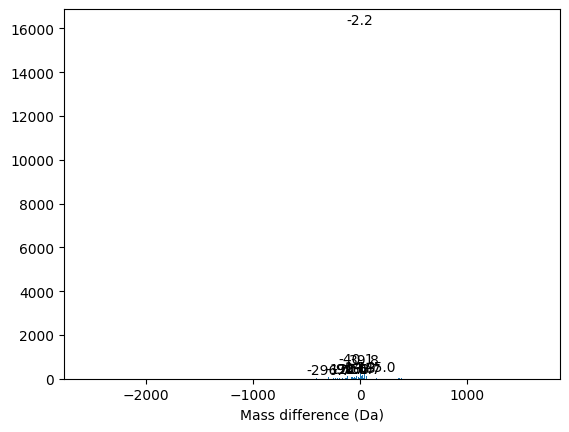

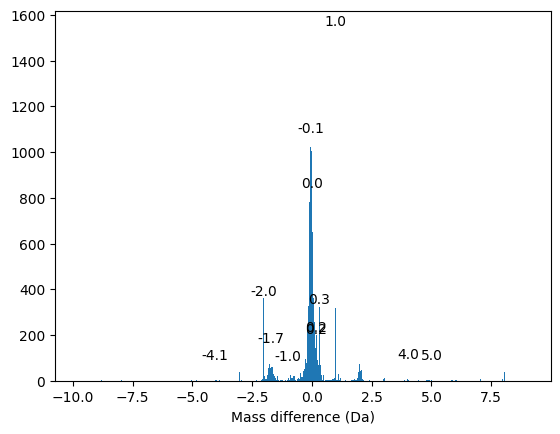

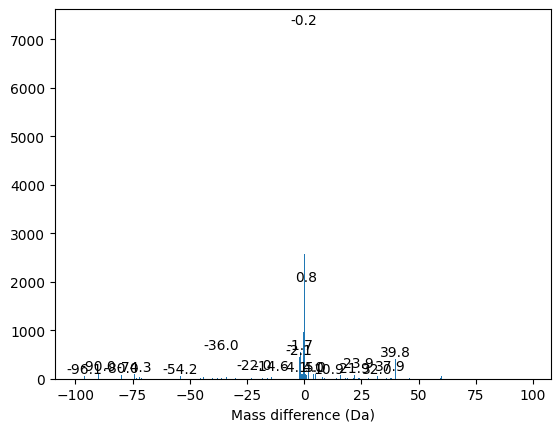

  0%|          | 0/13659 [00:00<?, ?it/s]

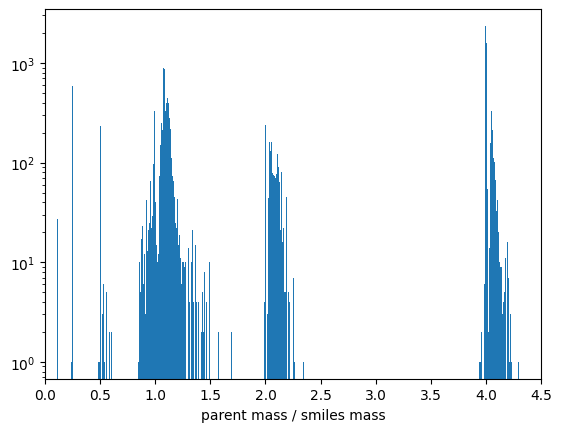

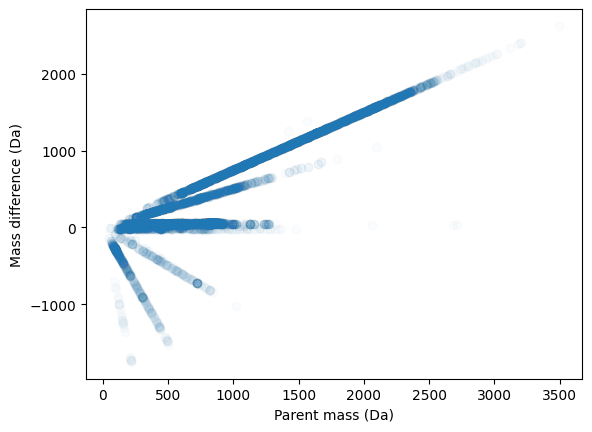

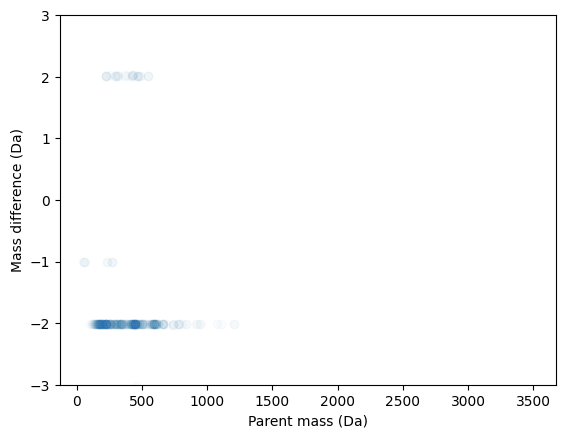

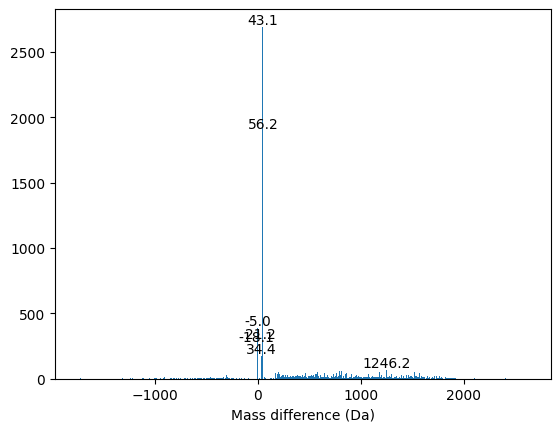

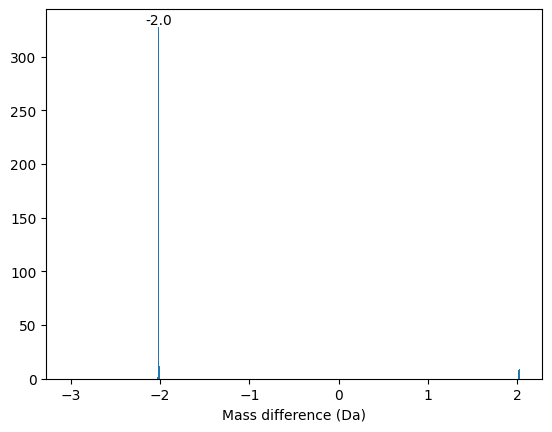

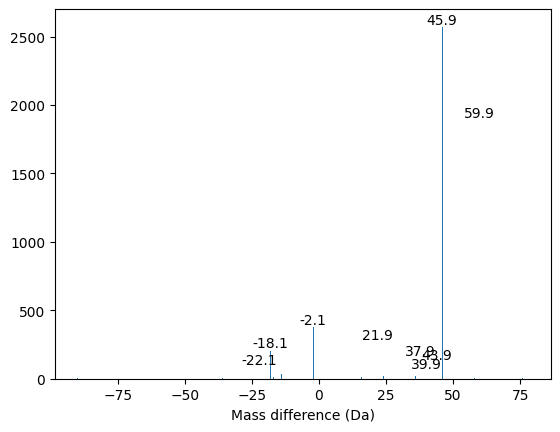

In [6]:
from matchms.filtering.repair_adduct.repair_adduct_based_on_smiles import repair_adduct_based_on_smiles

not_repaired, repaired = repair_spectra(not_repaired, mass_tolerance,
                                        "adduct_on_smiles", repair_adduct_based_on_smiles,
                                        accept_parent_mass_is_mol_wt=False)
plot_all(not_repaired)
plot_all(repaired)

  0%|          | 0/22406 [00:00<?, ?it/s]

[11:25:08] WARNING: not removing hydrogen atom without neighbors
[11:25:08] WARNING: not removing hydrogen atom without neighbors


2023-06-19 11:26:15,801:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 11:26:15,849:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 11:26:17,508:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 11:26:17,508:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 11:26:17,508:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 11:26:17,508:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 11:26:17,525:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 11:26:17,530:WARNING:matchms:repair_adduct_based_on

  0%|          | 0/22038 [00:00<?, ?it/s]

[11:26:50] WARNING: not removing hydrogen atom without neighbors


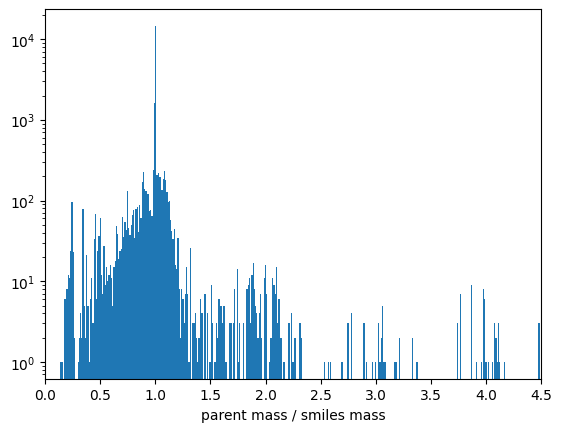

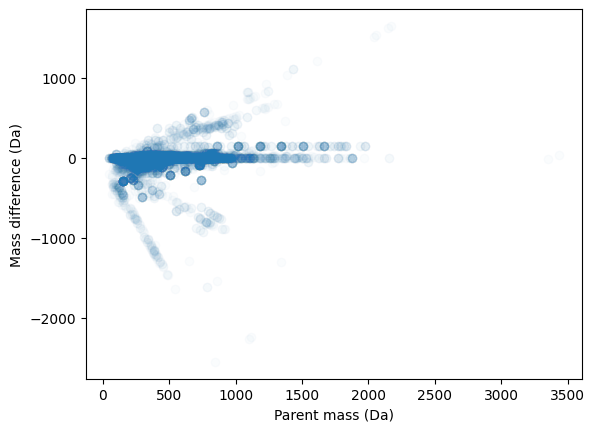

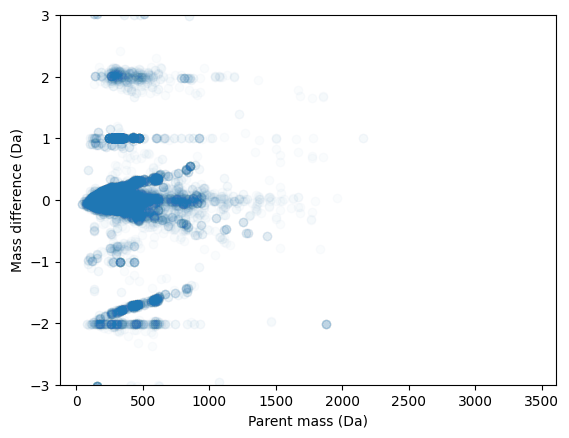

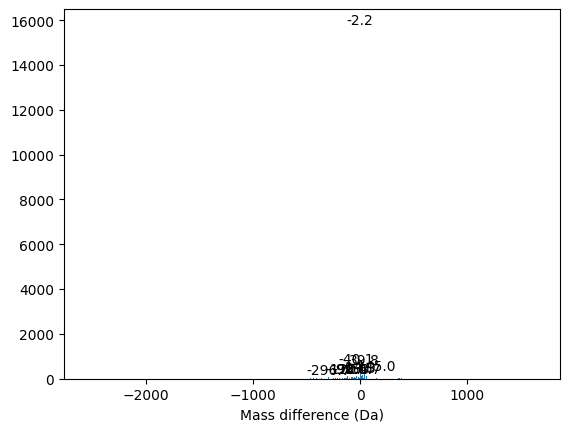

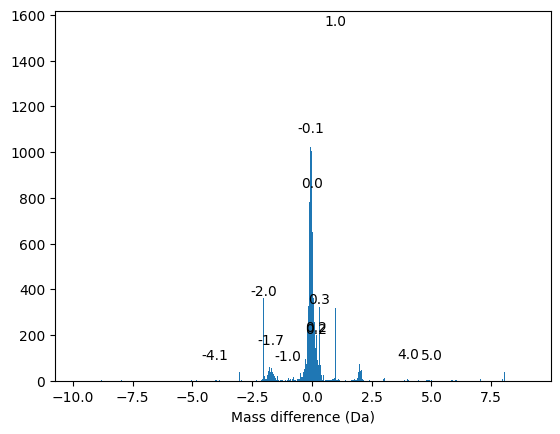

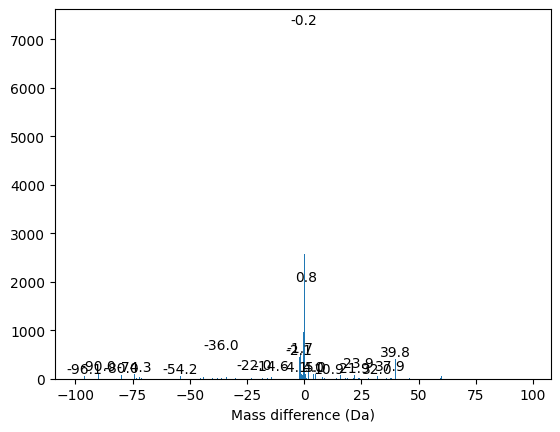

  0%|          | 0/368 [00:00<?, ?it/s]

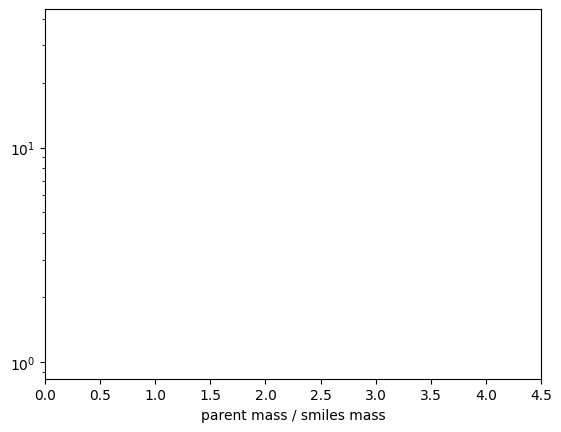

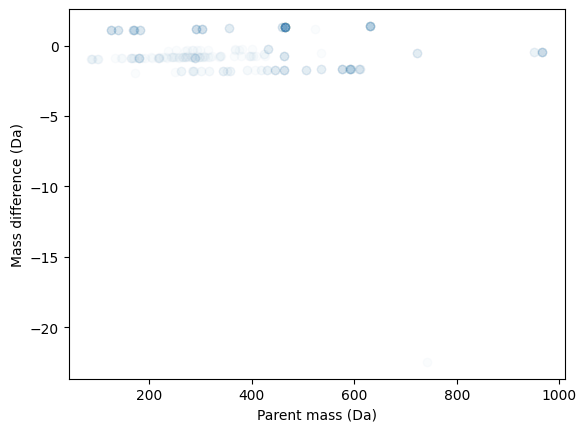

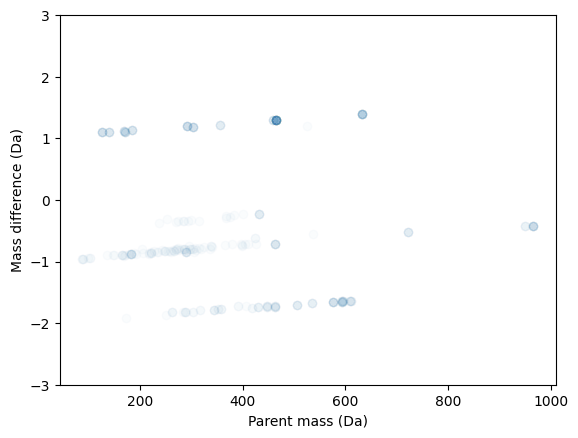

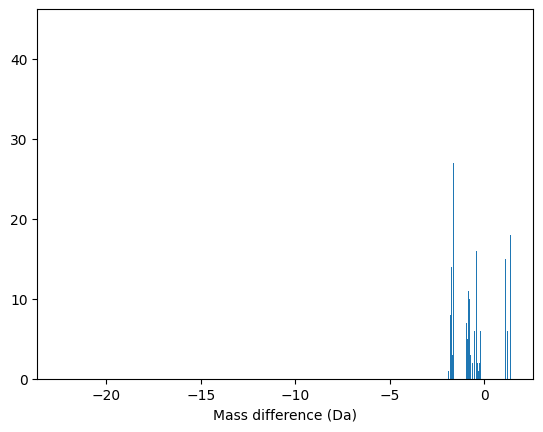

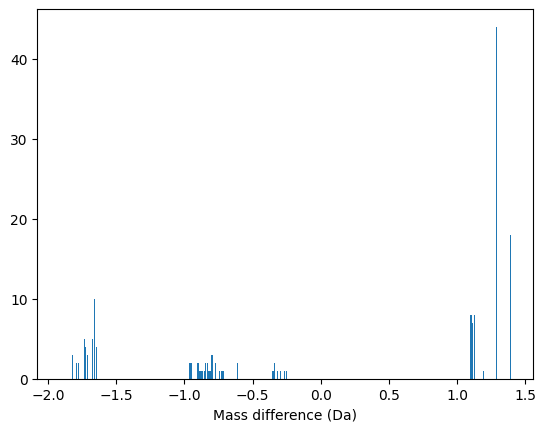

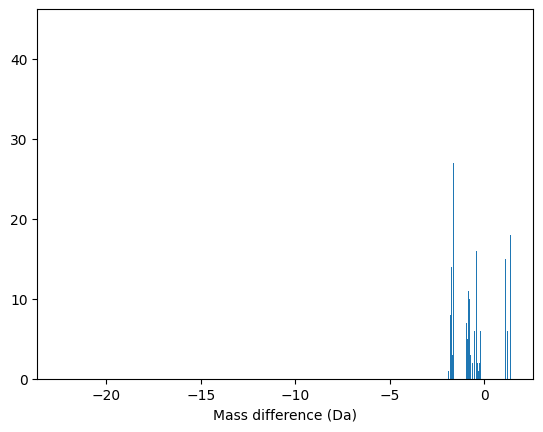

In [7]:
from matchms.filtering.repair_adduct.repair_adduct_based_on_smiles import repair_adduct_based_on_smiles

not_repaired, repaired = repair_spectra(not_repaired, mass_tolerance,
                                        "adduct_on_smiles_accept_pm_is_mol_wt", repair_adduct_based_on_smiles,
                                        accept_parent_mass_is_mol_wt=True)
plot_all(not_repaired)
plot_all(repaired)

# Mass tolerance = 0.1

In [4]:
mass_tolerance = 0.1

loaded in spectra


  0%|          | 0/30037 [00:00<?, ?it/s]

[18:19:16] WARNING: not removing hydrogen atom without neighbors


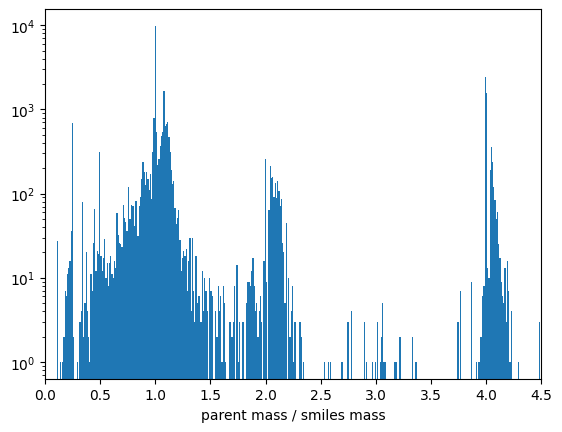

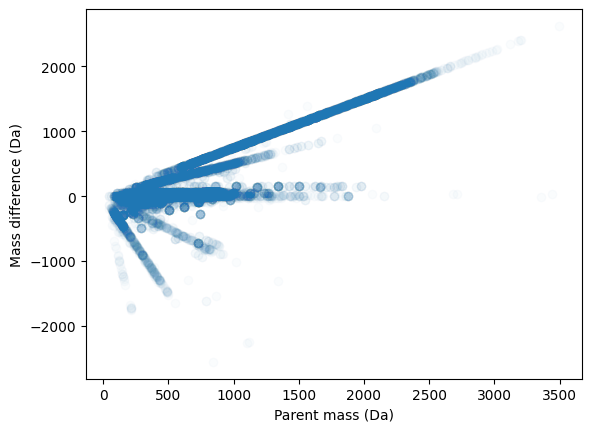

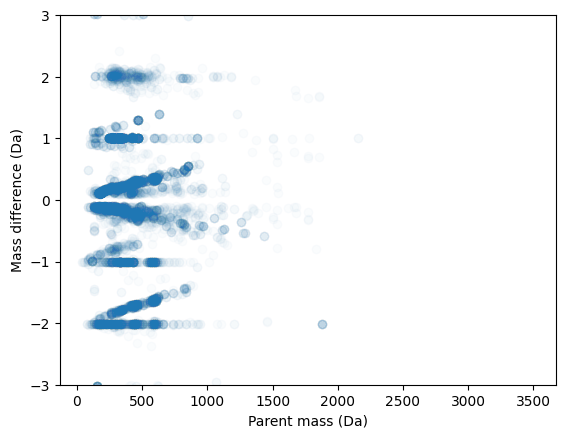

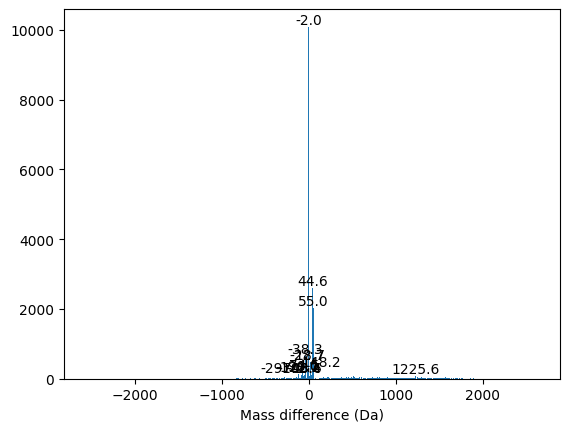

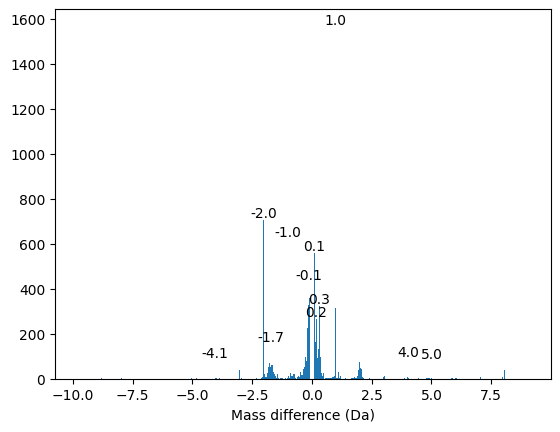

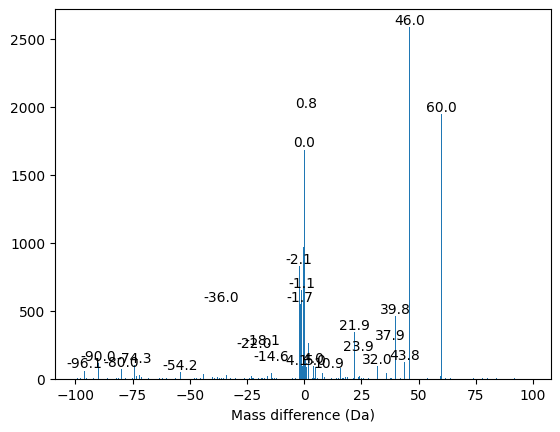

  0%|          | 0/326118 [00:00<?, ?it/s]

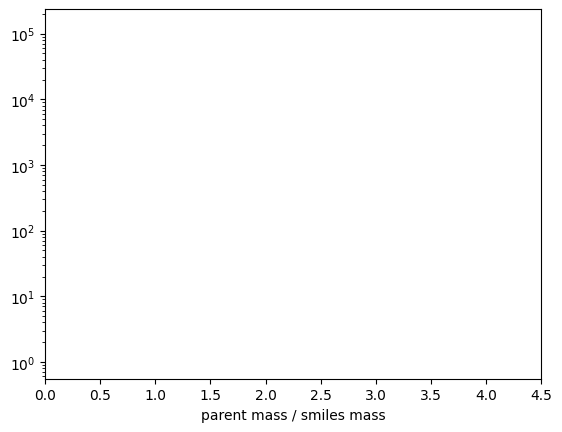

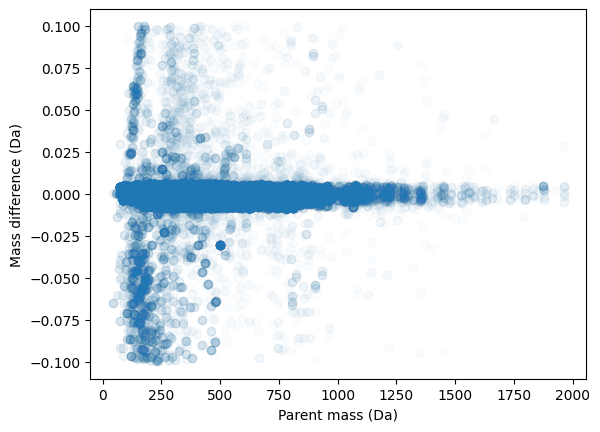

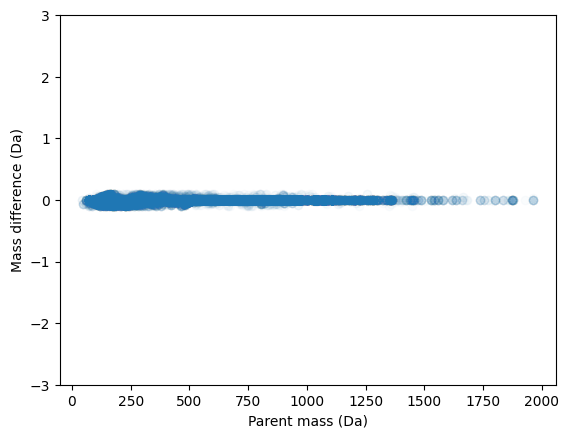

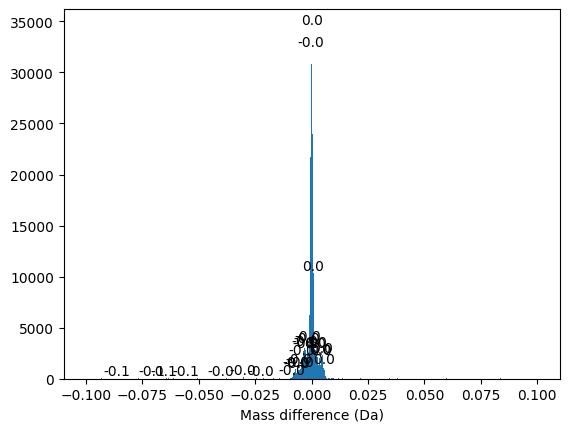

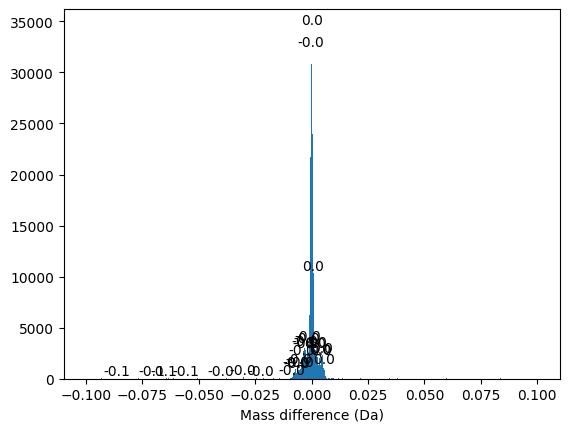

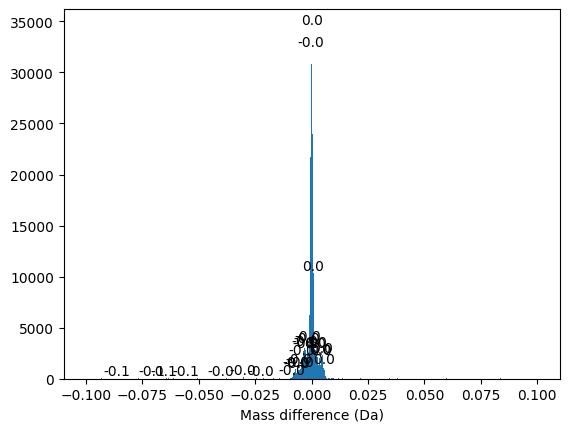

In [12]:
from matchms.filtering.repair_parent_mass_from_smiles.require_parent_mass_match_smiles import require_parent_mass_match_smiles

not_repaired, repaired = repair_spectra(annotated_spectra, mass_tolerance,
                                               "no_repair", require_parent_mass_match_smiles)
plot_all(not_repaired)
plot_all(repaired)

  0%|          | 0/30037 [00:00<?, ?it/s]

  0%|          | 0/28647 [00:00<?, ?it/s]

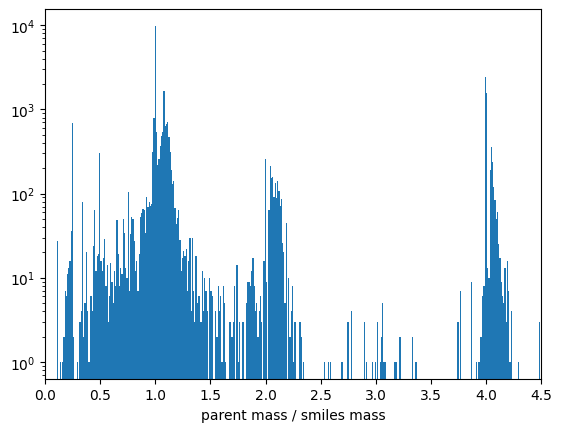

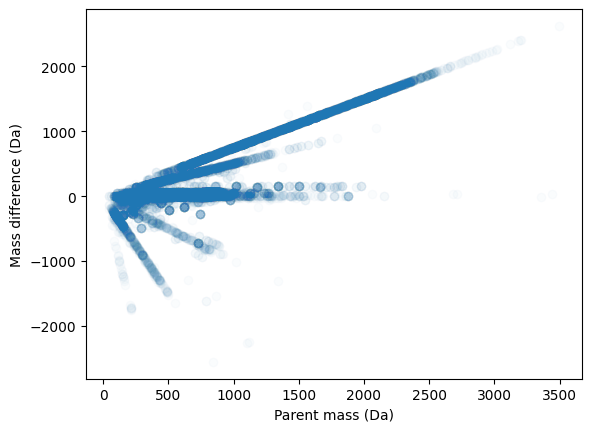

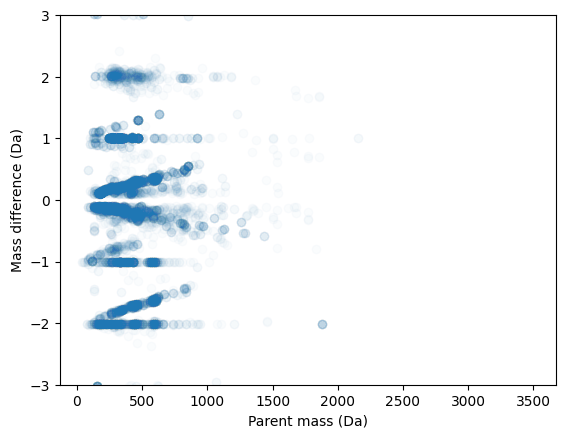

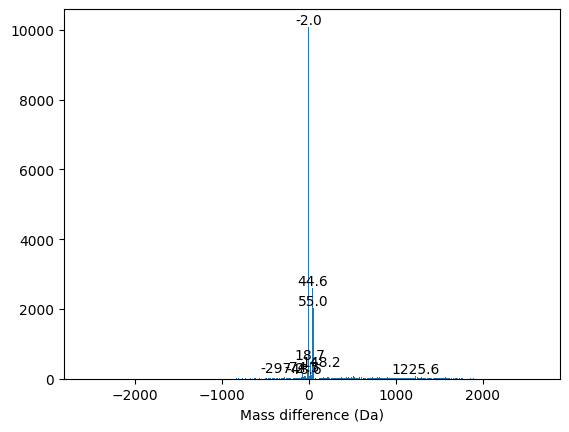

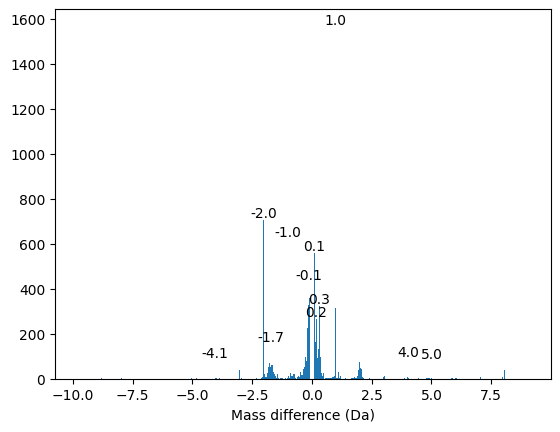

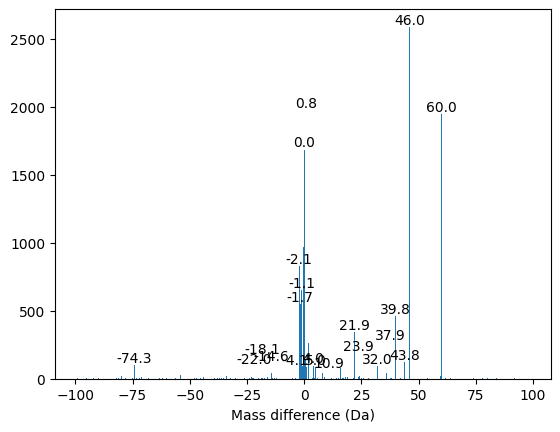

  0%|          | 0/1390 [00:00<?, ?it/s]

[18:07:13] WARNING: not removing hydrogen atom without neighbors


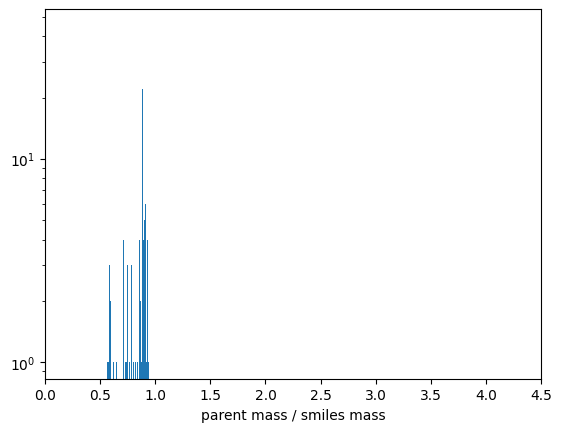

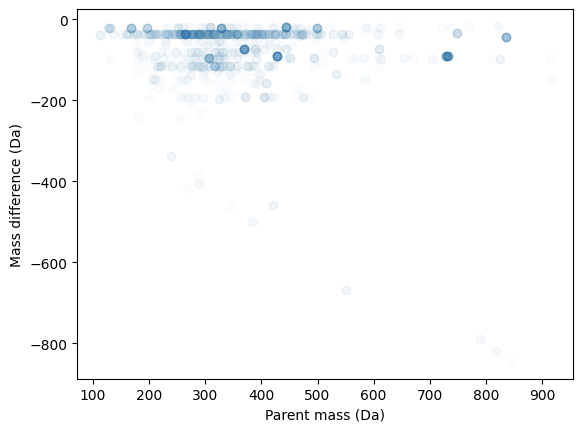

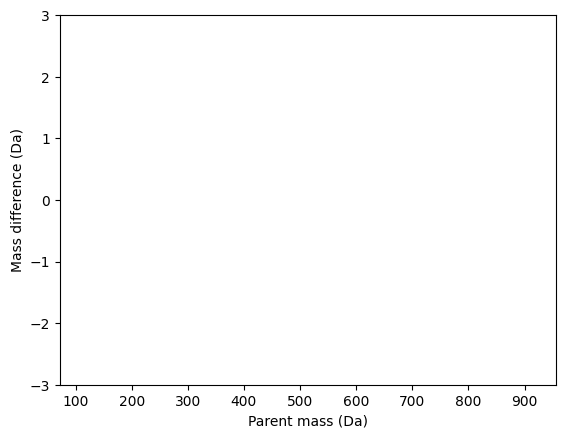

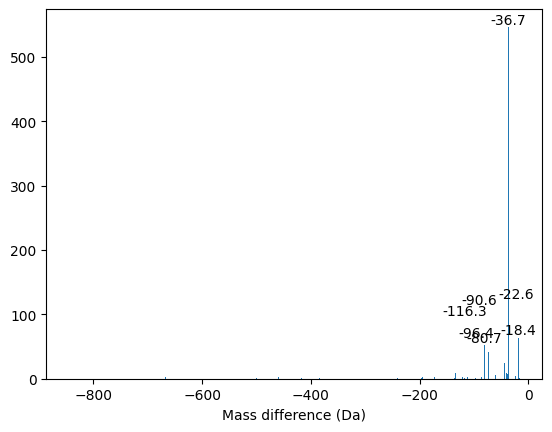

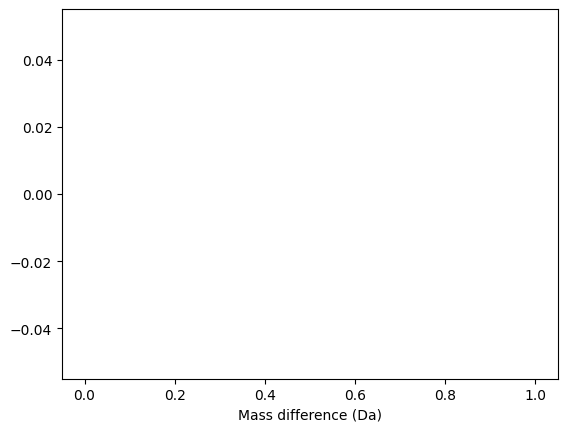

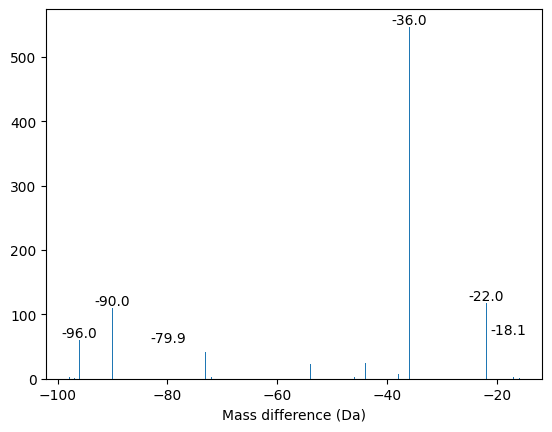

In [6]:
from matchms.filtering.repair_parent_mass_from_smiles.repair_smiles_salt_ions import repair_smiles_salt_ions

not_repaired, repaired = repair_spectra(not_repaired, mass_tolerance, "smiles_salt_ions", repair_smiles_salt_ions)
plot_all(not_repaired)
plot_all(repaired)

loaded in spectra


  0%|          | 0/27997 [00:00<?, ?it/s]

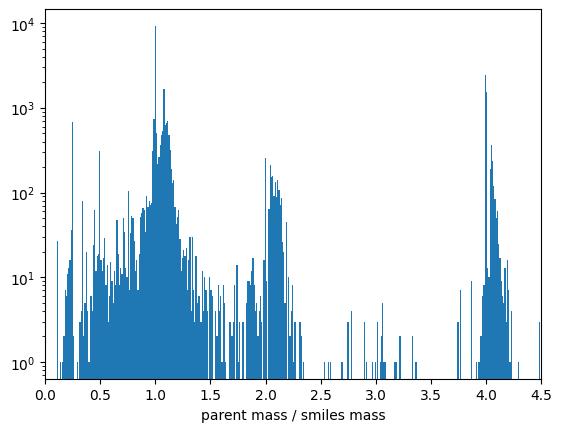

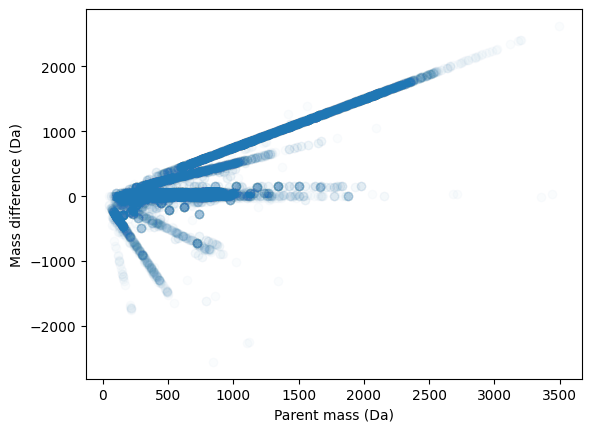

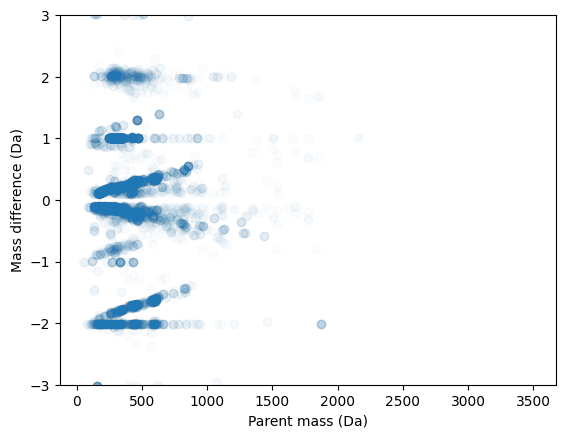

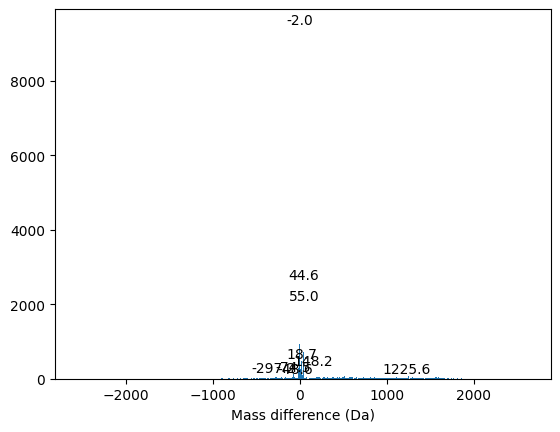

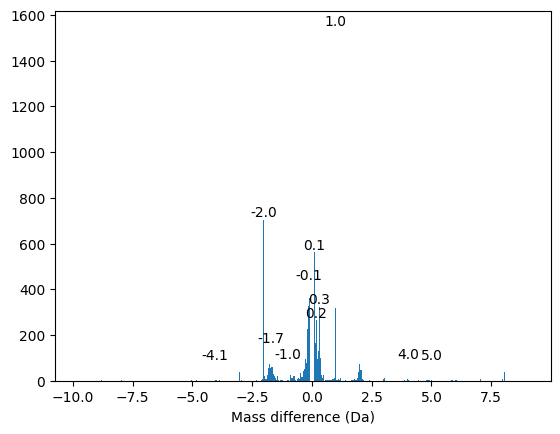

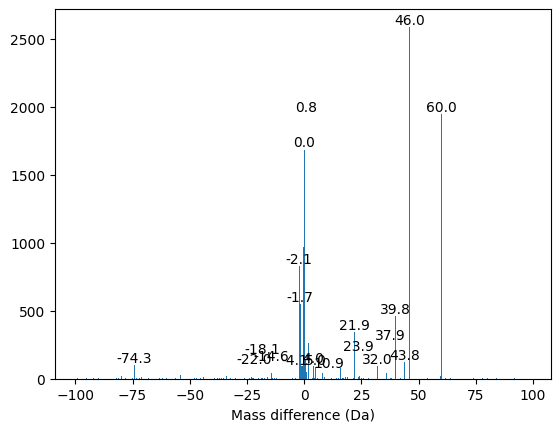

  0%|          | 0/650 [00:00<?, ?it/s]

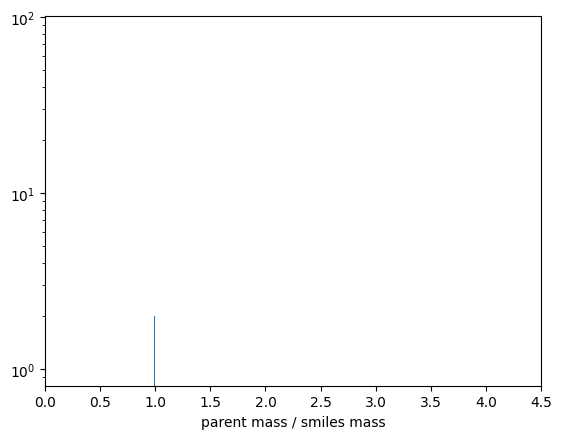

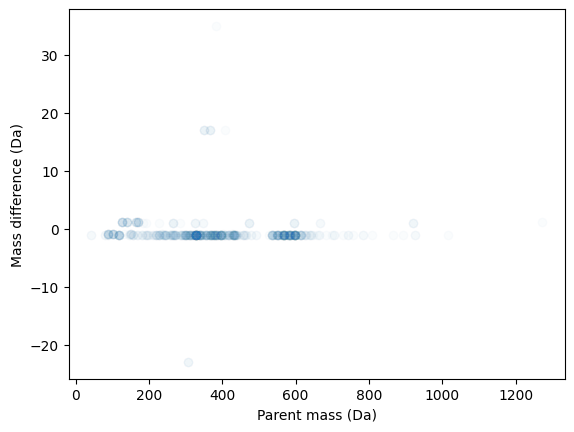

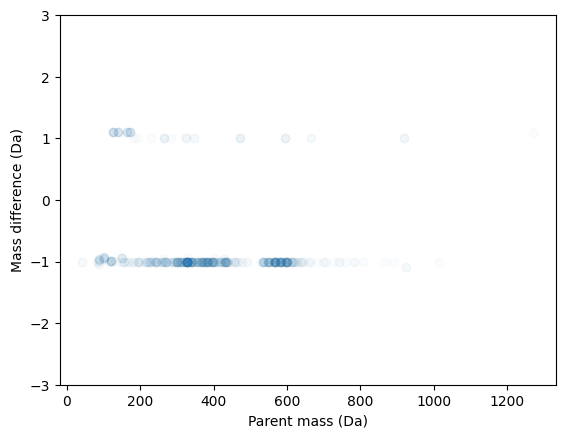

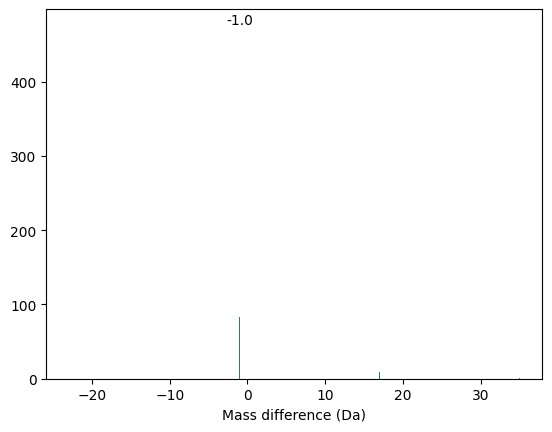

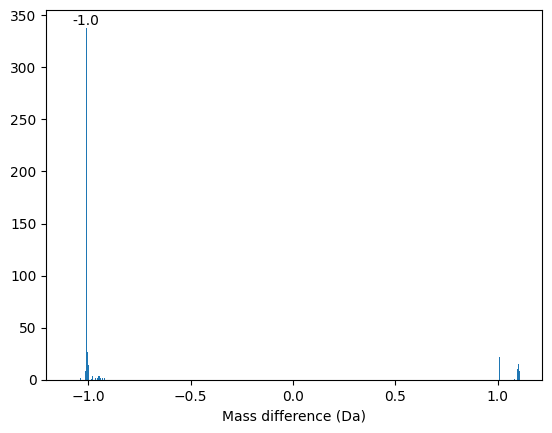

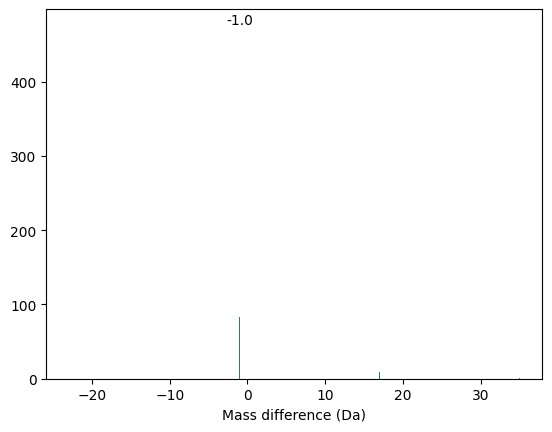

In [6]:
from matchms.filtering.repair_parent_mass_from_smiles.repair_precursor_is_parent_mass import repair_precursor_is_parent_mass

not_repaired, repaired = repair_spectra(not_repaired, mass_tolerance,
                                        "precursor_is_parent_mass",
                                        repair_precursor_is_parent_mass)
plot_all(not_repaired)
plot_all(repaired)

  0%|          | 0/27997 [00:00<?, ?it/s]

  0%|          | 0/25401 [00:00<?, ?it/s]

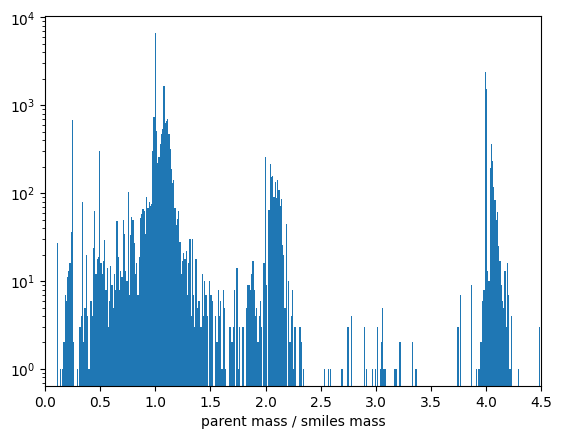

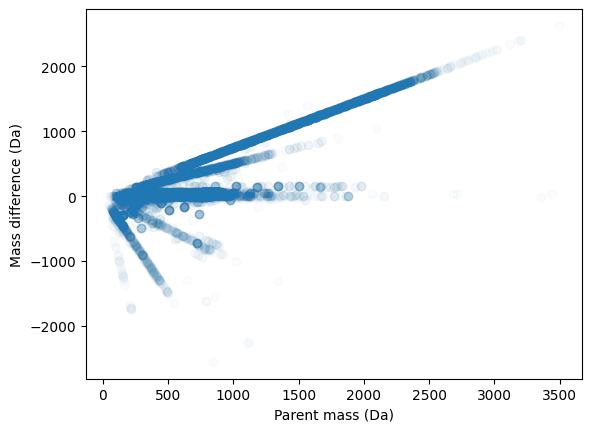

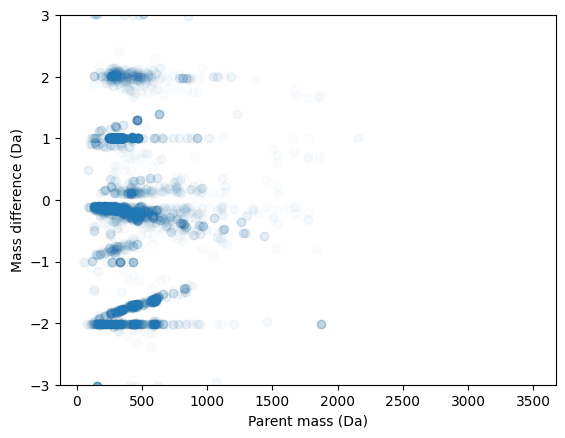

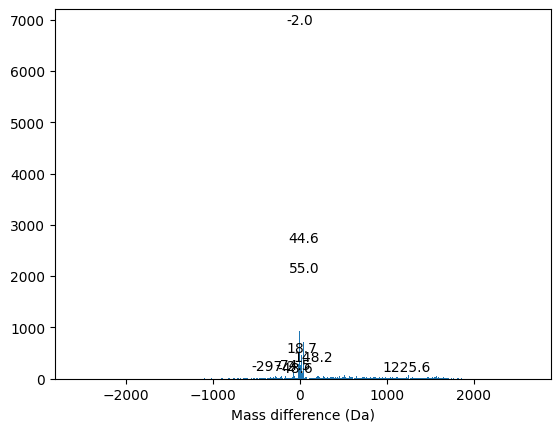

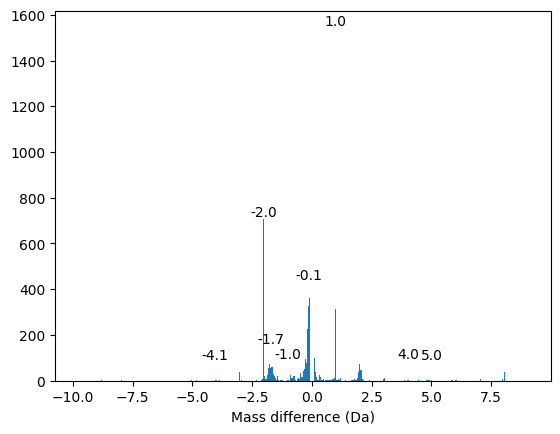

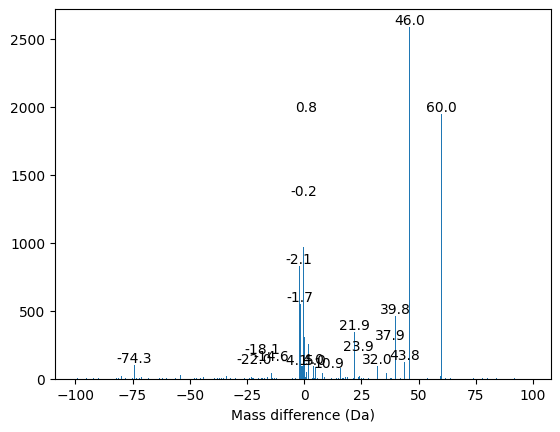

  0%|          | 0/2596 [00:00<?, ?it/s]

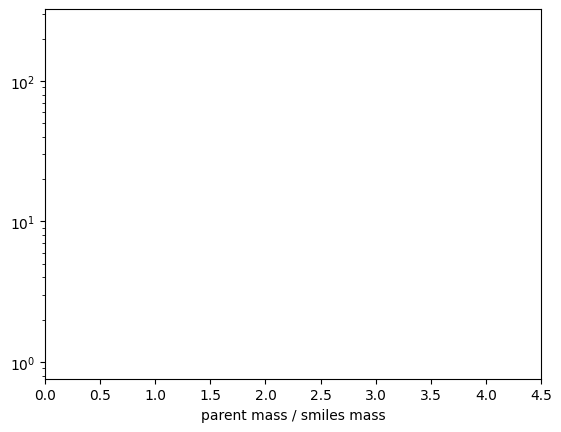

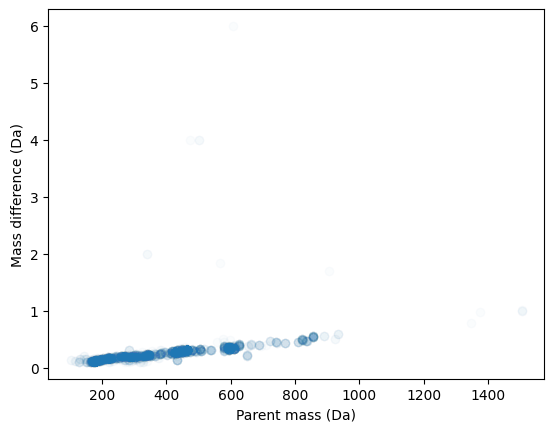

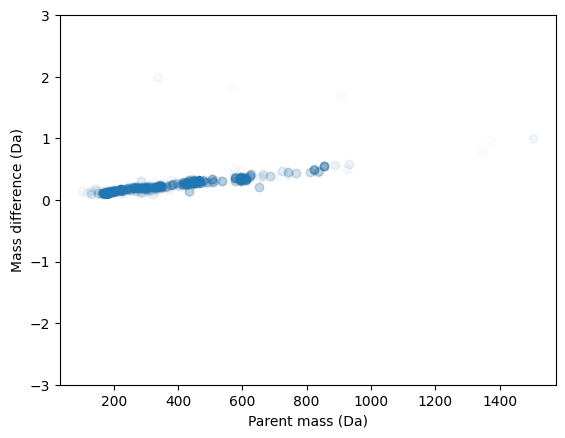

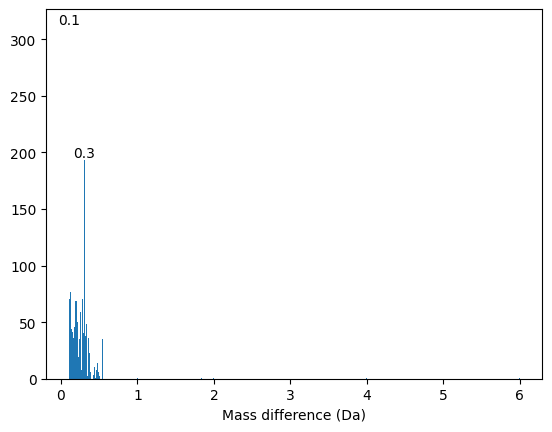

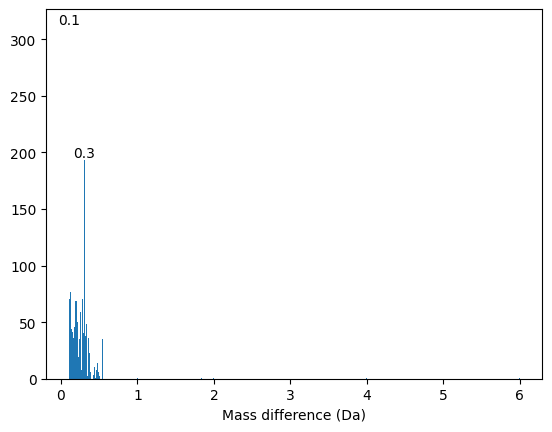

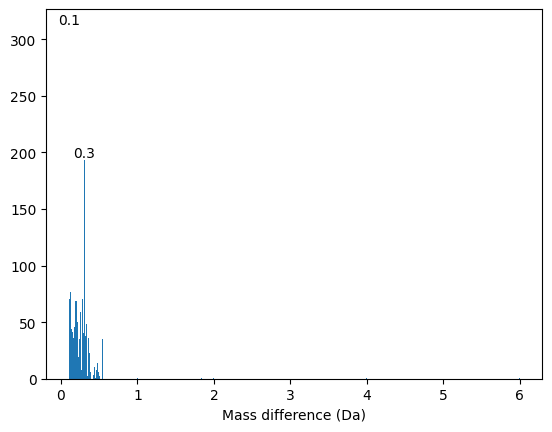

In [7]:
from matchms.filtering.repair_parent_mass_from_smiles.repair_parent_mass_is_mol_wt import repair_parent_mass_is_mol_wt

not_repaired, repaired = repair_spectra(not_repaired, mass_tolerance,
                                        "parent_mass_is_mol_wt", repair_parent_mass_is_mol_wt)
plot_all(not_repaired)
plot_all(repaired)


  0%|          | 0/25401 [00:00<?, ?it/s]

2023-06-13 18:12:55,116:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-13 18:12:55,141:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-13 18:12:55,666:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-13 18:12:55,669:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-13 18:12:55,679:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-13 18:12:55,682:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-13 18:12:55,684:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-13 18:12:55,688:WARNING:matchms:repair_adduct_based_on

  0%|          | 0/11646 [00:00<?, ?it/s]

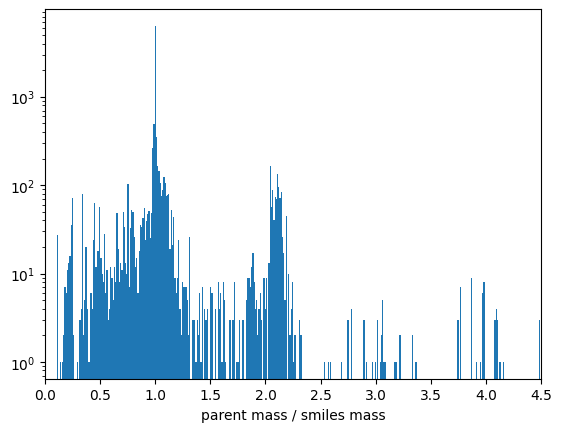

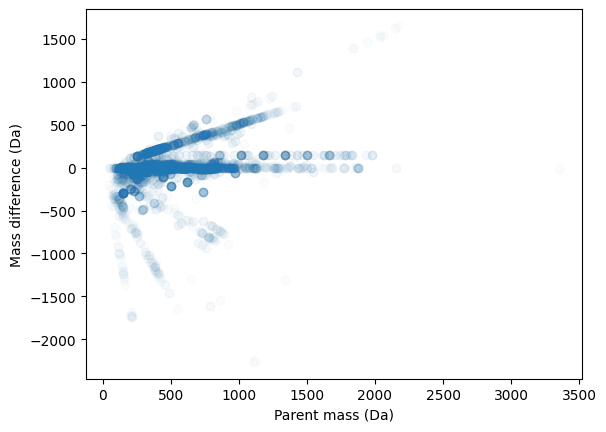

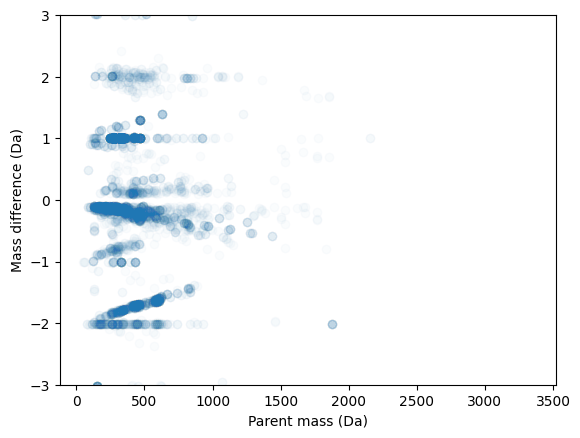

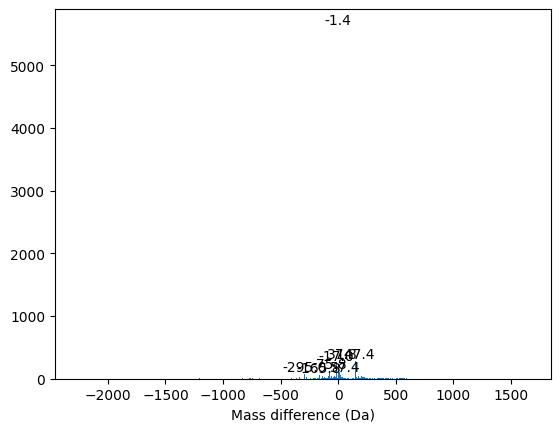

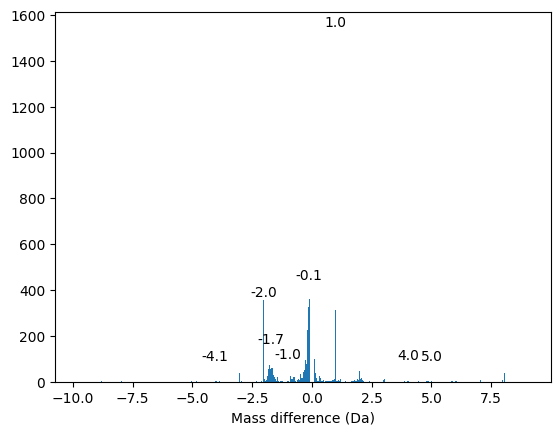

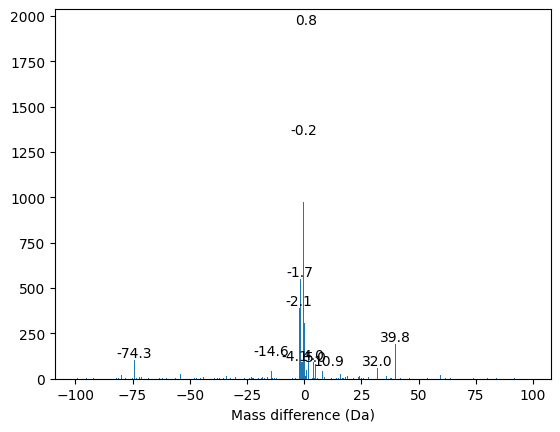

  0%|          | 0/13755 [00:00<?, ?it/s]

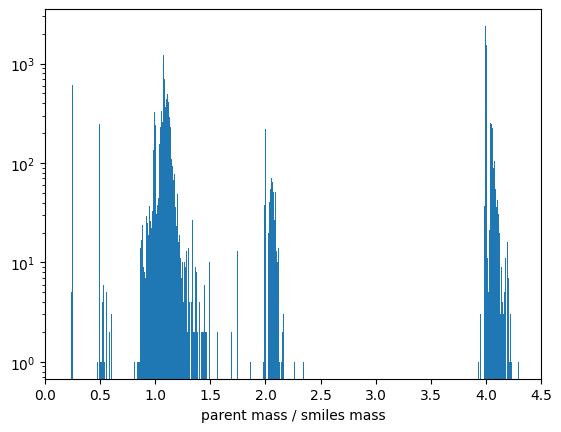

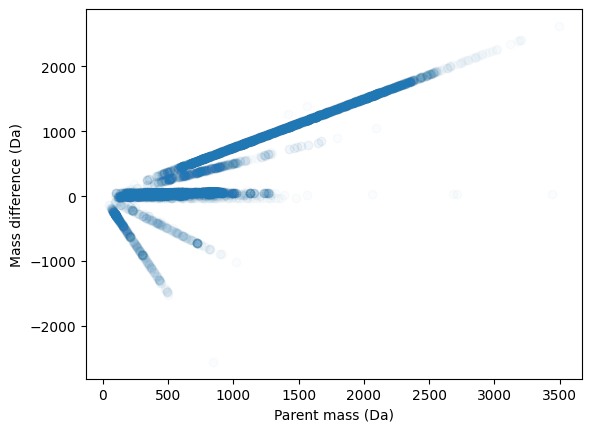

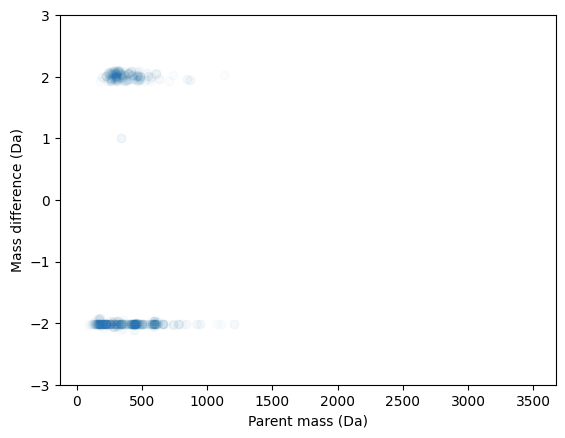

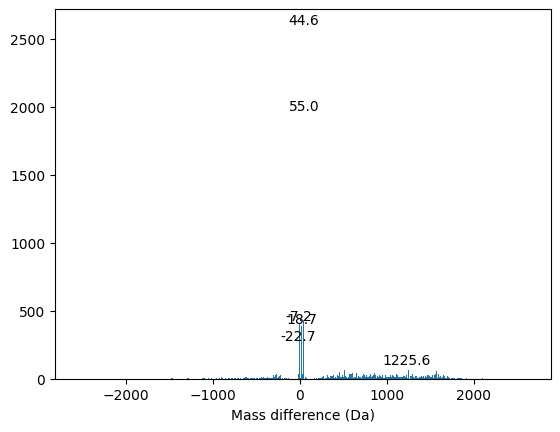

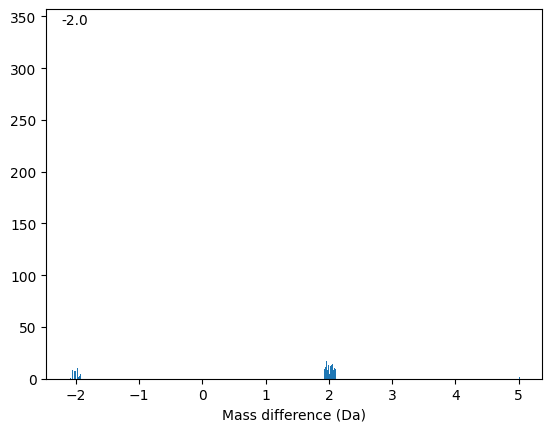

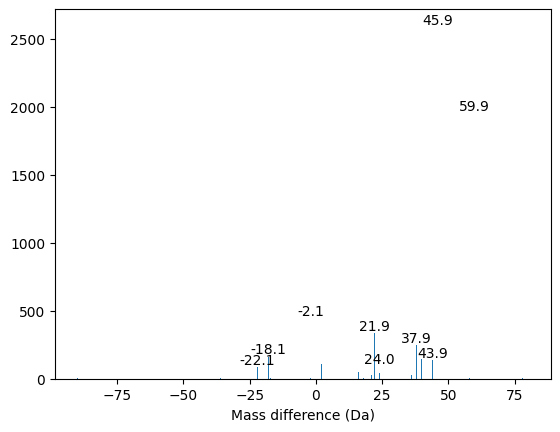

In [8]:
from matchms.filtering.repair_parent_mass_from_smiles.repair_adduct_based_on_smiles import repair_adduct_based_on_smiles

not_repaired, repaired = repair_spectra(not_repaired, mass_tolerance,
                                        "adduct_on_smiles", repair_adduct_based_on_smiles,
                                        accept_parent_mass_is_mol_wt=False)
plot_all(not_repaired)
plot_all(repaired)

  0%|          | 0/11646 [00:00<?, ?it/s]

2023-06-13 18:13:45,246:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-13 18:13:45,275:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-13 18:13:45,988:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-13 18:13:45,994:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-13 18:13:46,001:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-13 18:13:46,004:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-13 18:13:46,006:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-13 18:13:46,011:WARNING:matchms:repair_adduct_based_on

  0%|          | 0/11238 [00:00<?, ?it/s]

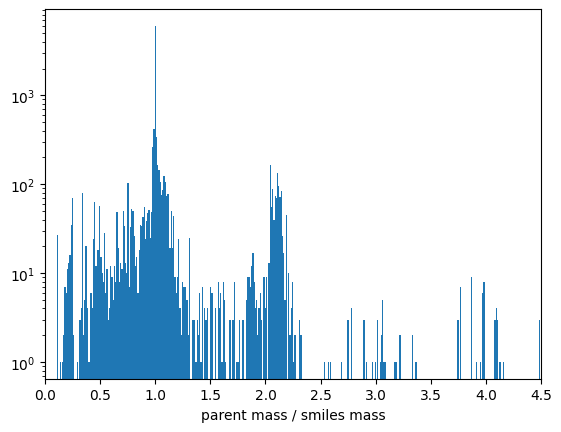

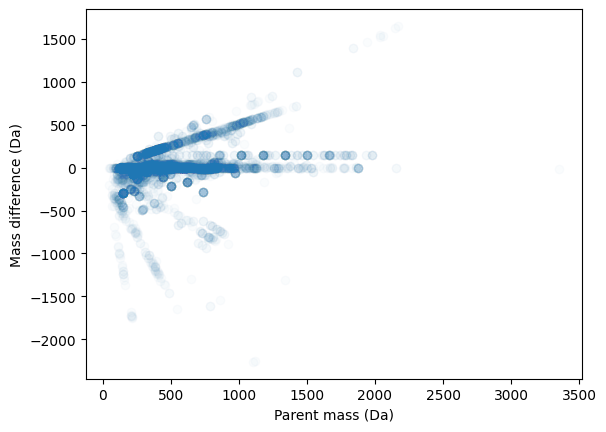

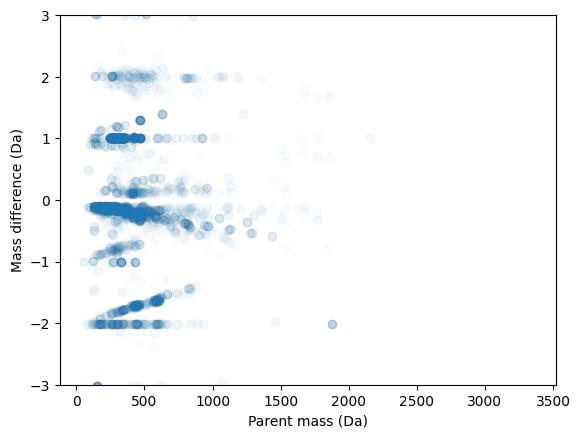

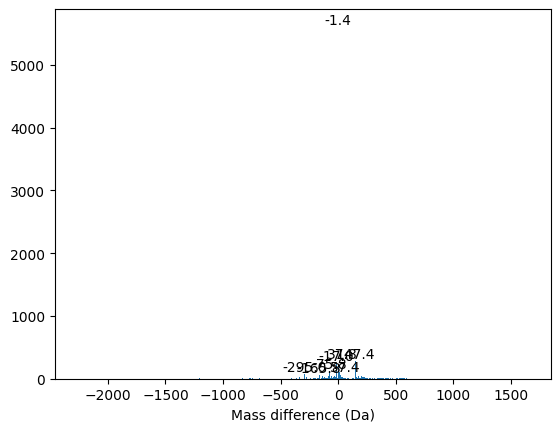

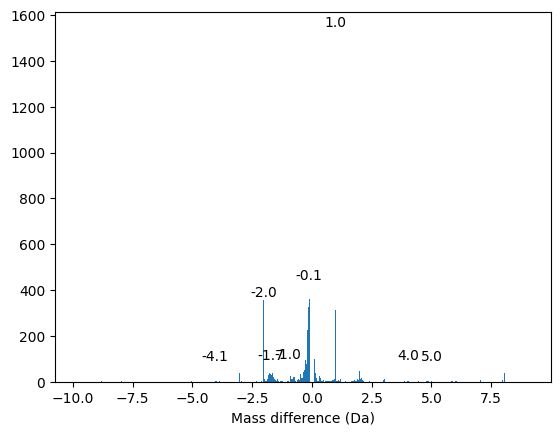

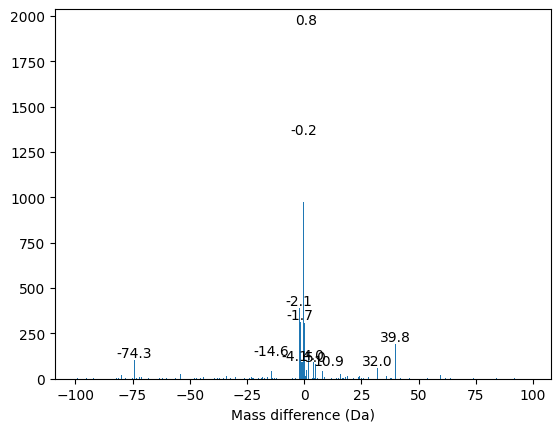

  0%|          | 0/408 [00:00<?, ?it/s]

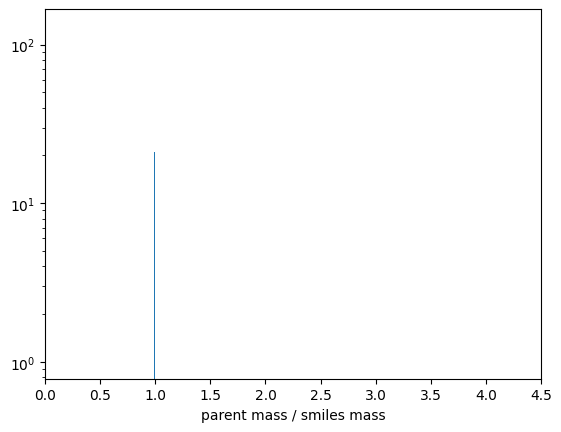

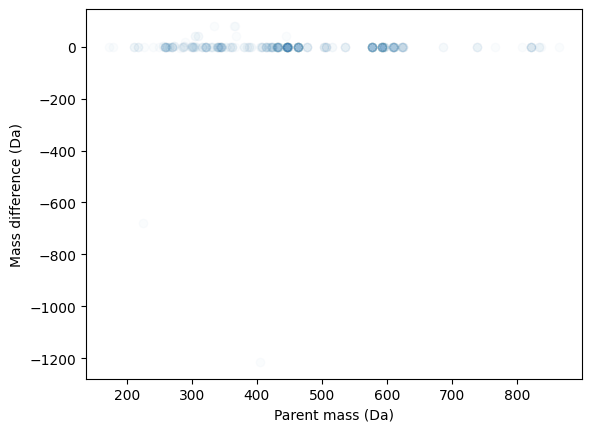

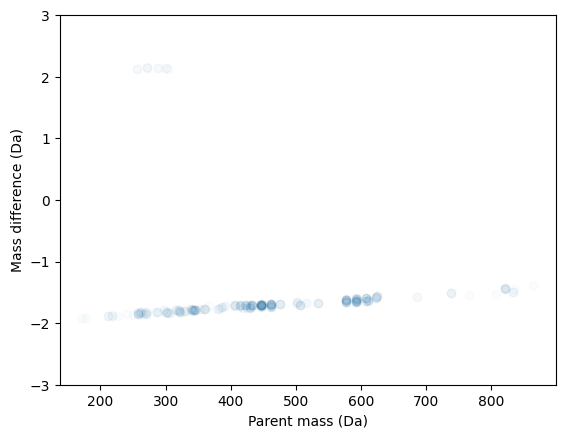

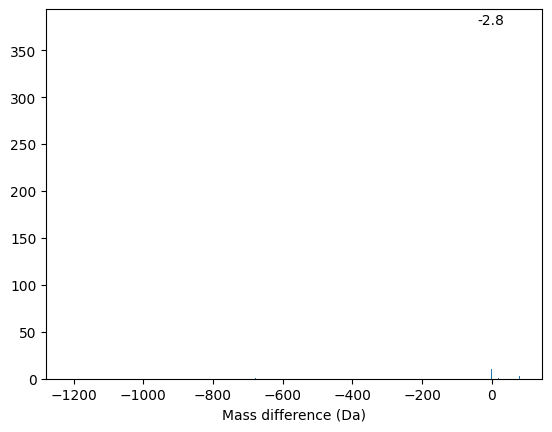

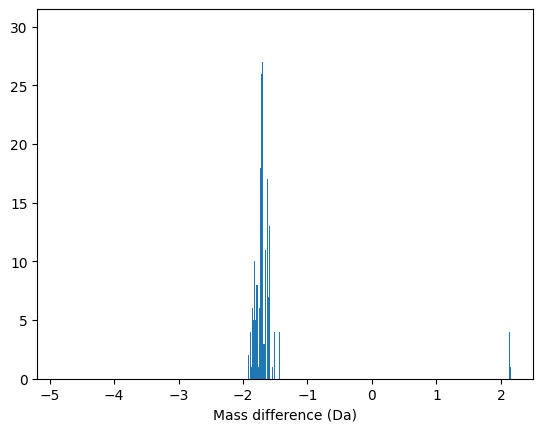

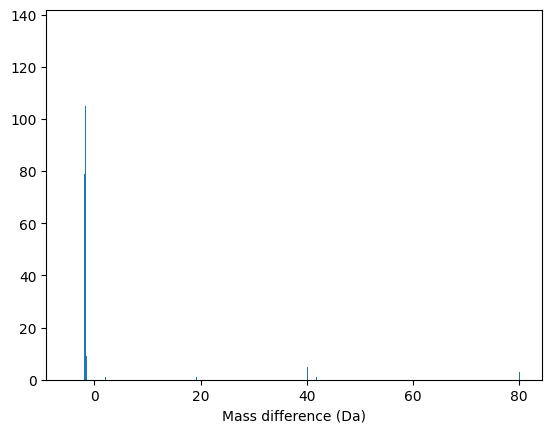

In [9]:
from matchms.filtering.repair_parent_mass_from_smiles.repair_adduct_based_on_smiles import repair_adduct_based_on_smiles

not_repaired, repaired = repair_spectra(not_repaired, mass_tolerance,
                                        "adduct_on_smiles_accept_pm_is_mol_wt", repair_adduct_based_on_smiles,
                                        accept_parent_mass_is_mol_wt=True)
plot_all(not_repaired)
plot_all(repaired)

The spectra left all have manually added precursor mz, since the number of decimals is low

In [11]:
for spectrum in not_repaired:
    print(spectrum.get("precursor_mz"))

940.25
456.1
545.0
689.0
591.0
567.0
589.0
491.0
489.0
511.0
463.0
532.0
484.0
672.1
497.9
498.1
424.0
607.9
608.0
687.1
427.0
840.0
862.0
826.0
848.0
736.0
738.0
693.0
715.0
691.0
713.0
759.23
739.21
785.23
969.29
879.34
901.4
432.0
484.0
754.34
712.31
338.0
789.0
500.0
516.031
565.76
818.22
1532.0
1533.0
1502.5
1503.6
1533.4
1502.47
664.66
666.64
838.3
384.0
469.0
492.0
855.0
396.0
567.0
587.0
491.0
950.0
964.0
367.0
830.0
826.0
548.0
546.0
570.0
572.0
568.0
399.5
511.2
450.8
490.0
926.2
948.2
928.2
930.1
950.2
485.0
487.0
304.0
360.0
601.6
905.0
928.0
789.4
789.4
316.0
339.9
326.1
825.3
847.3
490.9
608.0
1532.4
1554.6
1555.5
828.3
814.2
487.2
834.3
488.1
804.4
767.2
769.2
593.2
260.0
853.0
875.0
891.0
687.08
705.1
515.92
531.99
1074.76
446.82
505.49
516.87
523.87
519.5
498.07
1134.64
571.311
571.311
571.311
571.311
549.329
549.329
549.329
549.329
512.247
512.247
512.247
512.247
512.247
957.43
929.29
943.35
867.25
881.18
629.083
645.076
799.234
221.025
796.458
1461.83
1475.85
1477.82

In [15]:
# run directly after the first filter step. So these spectra were not needed to be filtered.
# This shows normal spectra do actually contain more decimals
# but that actually is not true... need to do more tests.
for spectrum in repaired[:10000]:
    print(spectrum.get("precursor_mz"))


981.54
667.115
1025.61
665.115
1065.6
687.0
730.418
752.399
860.584
866.633
888.615
513.308
461.0
535.29
515.322
537.304
850.636
348.155
1062.61
610.416
632.398
323.258
345.24
727.32
749.288
601.358
623.339
410.282
432.264
410.282
879.461
901.443
656.306
678.29
737.4
396.274
418.256
445.113
467.095
718.286
665.115
696.304
467.208
311.115
809.312
672.437
694.42
761.4
827.492
763.37
412.272
434.254
544.0
566.0
694.27
579.0
811.6
284.2
825.5
513.2
630.3
850.4
836.4
510.2
1141.5
1163.5
526.3
526.3
826.4
771.3
793.4
743.4
197.0
211.0
224.0
181.0
325.0
211.0
211.0
378.16
347.15
349.17
349.17
749.25
379.18
1255.62
277.11
273.07
688.39
726.3
710.4
414.13
1008.73
1046.71
1030.71
1022.73
1060.73
1044.7
1036.74
1058.72
1111.63
1149.6
245.128
245.128
245.128
245.128
245.128
211.145
211.145
211.145
211.145
211.145
556.32
556.32
556.32
556.32
556.32
261.159
261.159
261.159
261.159
261.159
304.226
304.226
304.226
304.226
304.226
304.226
304.226
304.226
304.226
304.226
304.226
304.226
304.226
304.226


Mass tolerance = 0.2

loaded in spectra


  0%|          | 0/26932 [00:00<?, ?it/s]

[10:18:33] WARNING: not removing hydrogen atom without neighbors


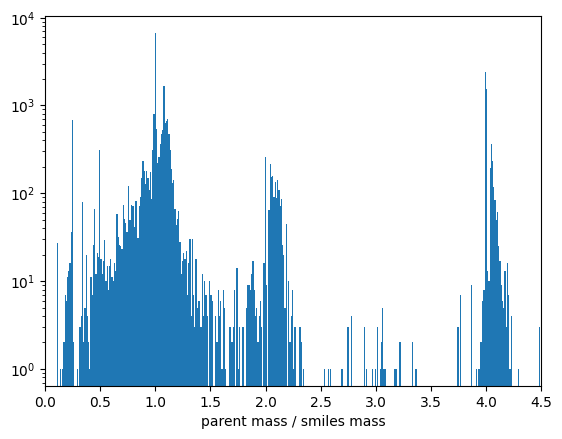

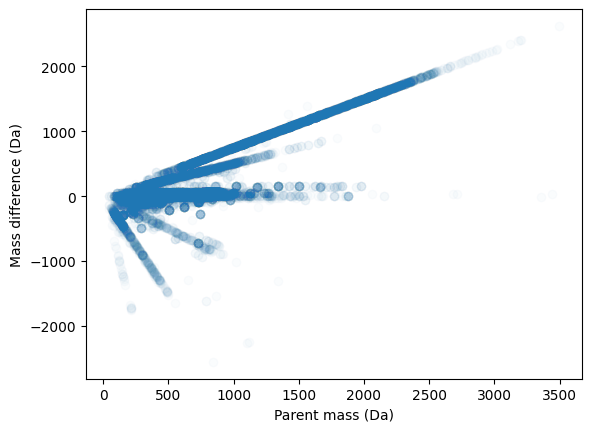

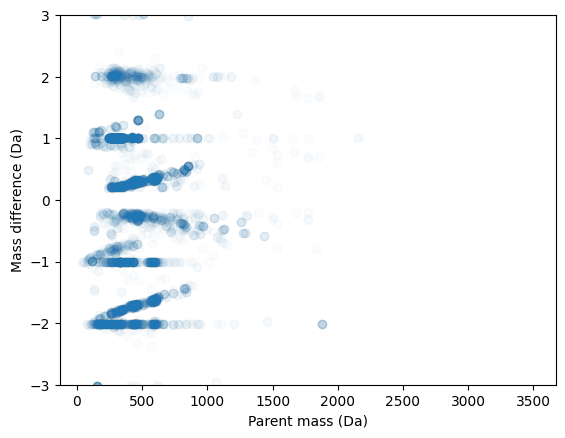

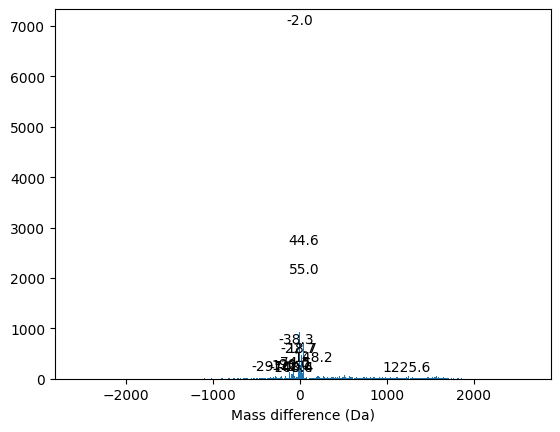

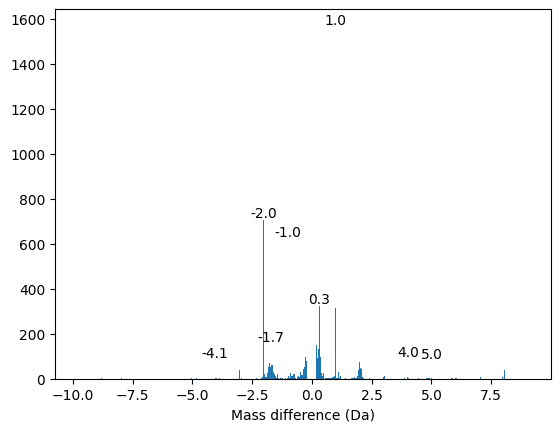

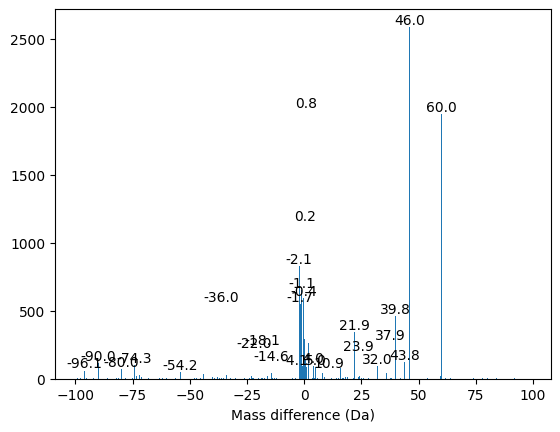

In [6]:
mass_tolerance = 0.2
from matchms.filtering.repair_parent_mass_from_smiles.require_parent_mass_match_smiles import require_parent_mass_match_smiles

not_repaired, repaired = repair_spectra(annotated_spectra, mass_tolerance,
                                               "no_repair", require_parent_mass_match_smiles)
plot_all(not_repaired)
# plot_all(repaired)

  0%|          | 0/26932 [00:00<?, ?it/s]

  0%|          | 0/25540 [00:00<?, ?it/s]

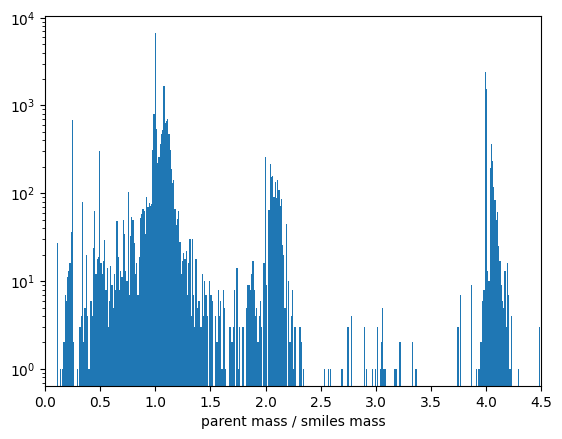

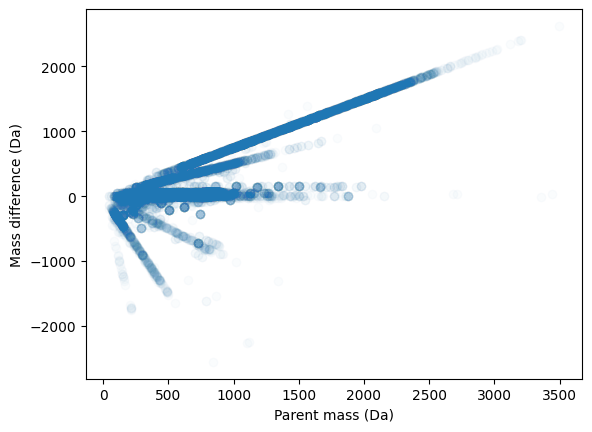

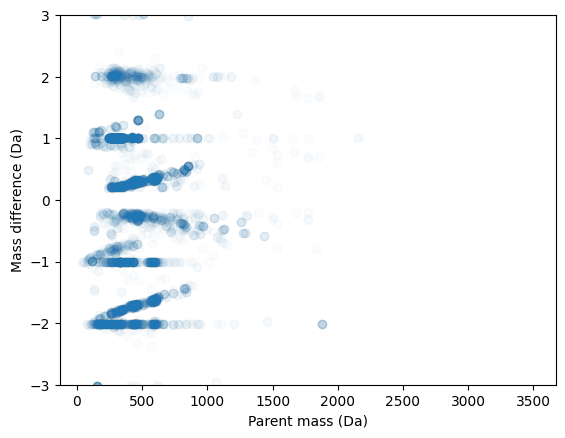

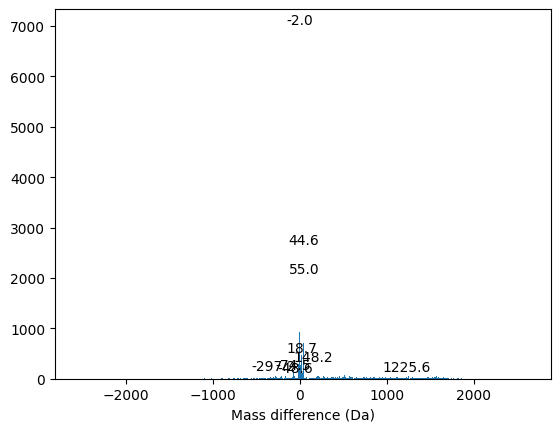

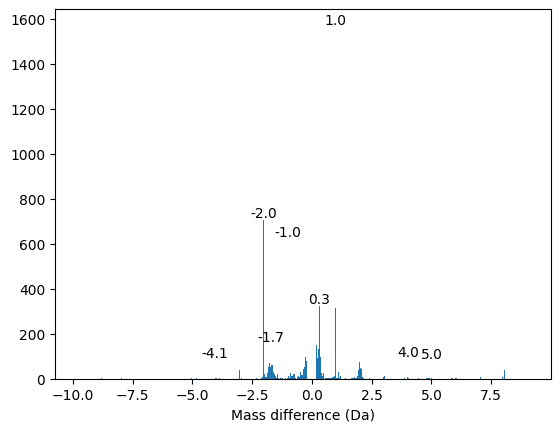

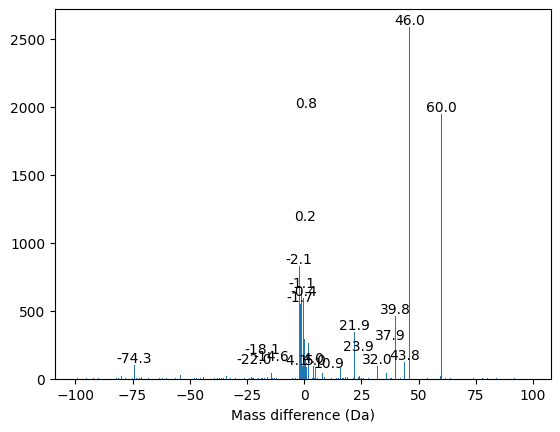

  0%|          | 0/1392 [00:00<?, ?it/s]

[10:19:50] WARNING: not removing hydrogen atom without neighbors


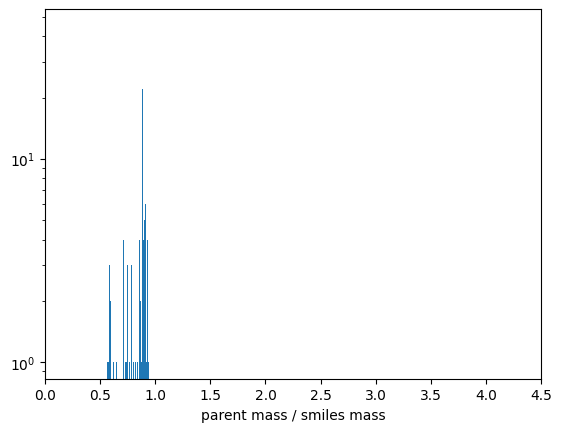

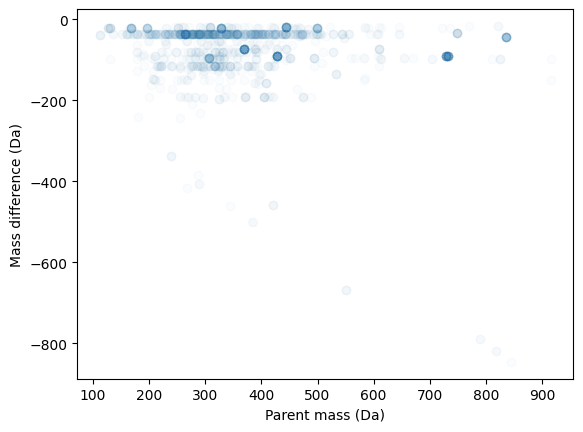

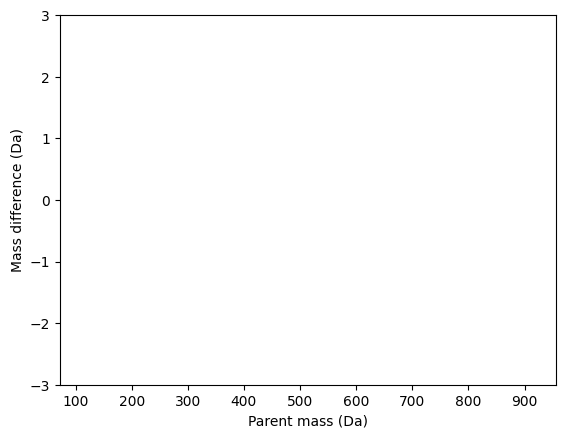

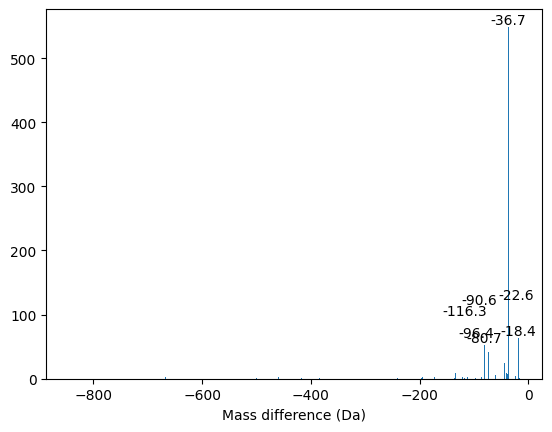

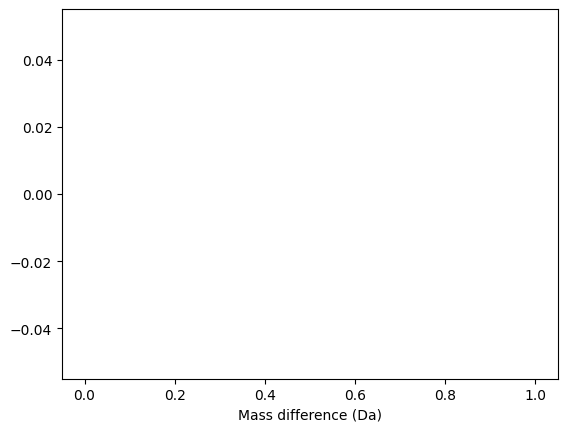

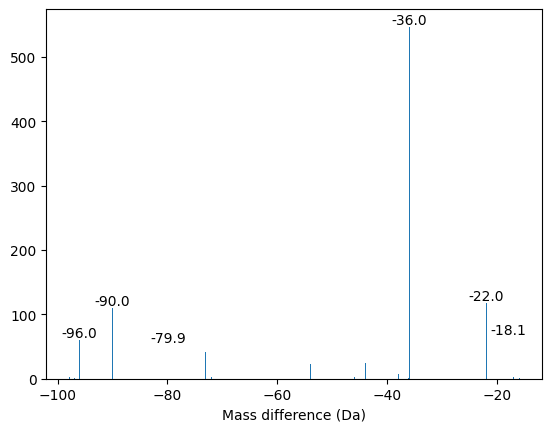

In [7]:
from matchms.filtering.repair_parent_mass_from_smiles.repair_smiles_salt_ions import repair_smiles_salt_ions

not_repaired, repaired = repair_spectra(not_repaired, mass_tolerance, "smiles_salt_ions", repair_smiles_salt_ions)
plot_all(not_repaired)
plot_all(repaired)

loaded in spectra


  0%|          | 0/24773 [00:00<?, ?it/s]

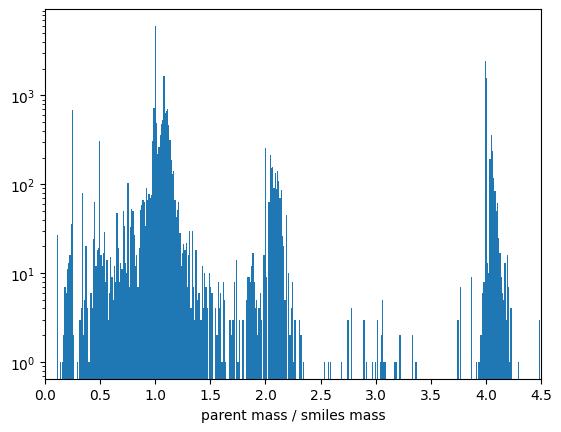

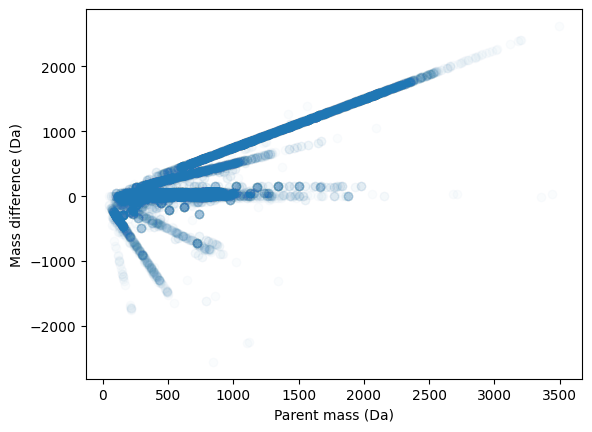

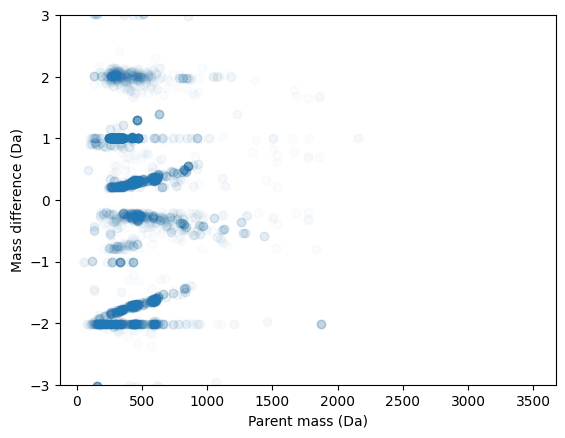

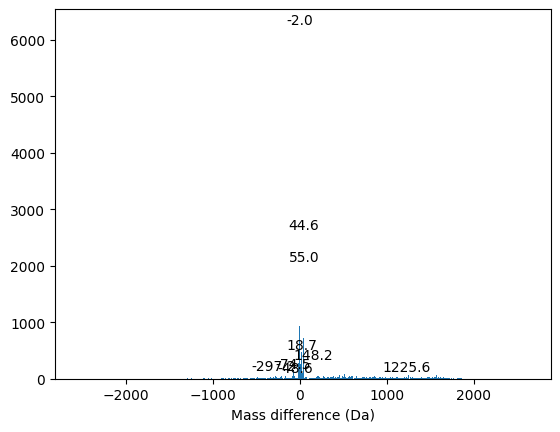

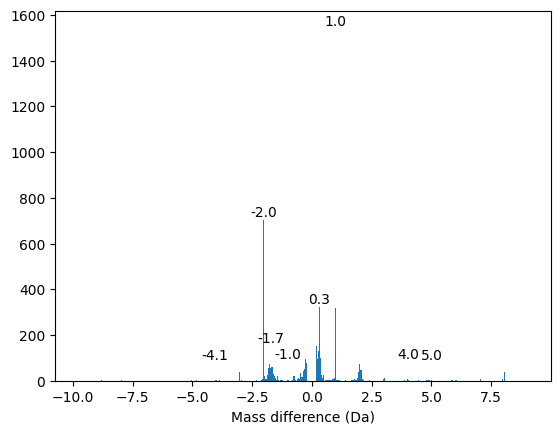

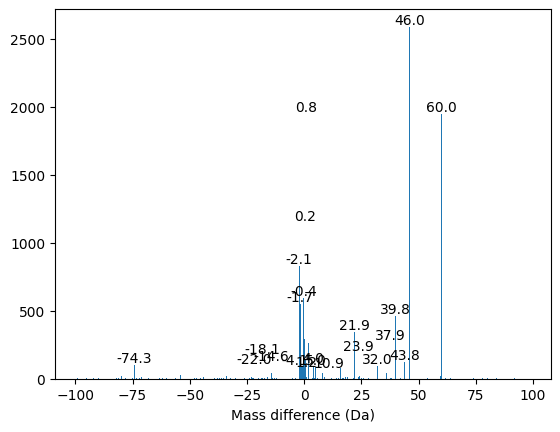

  0%|          | 0/767 [00:00<?, ?it/s]

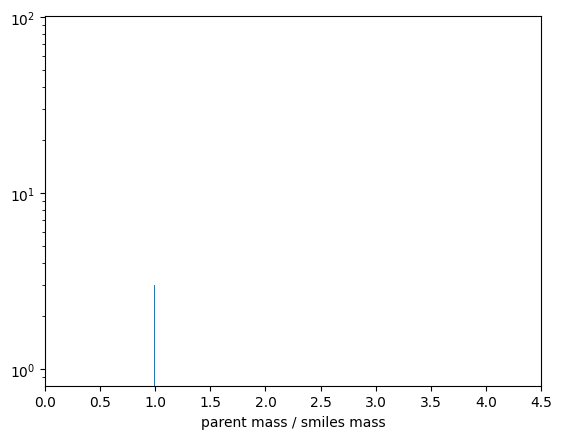

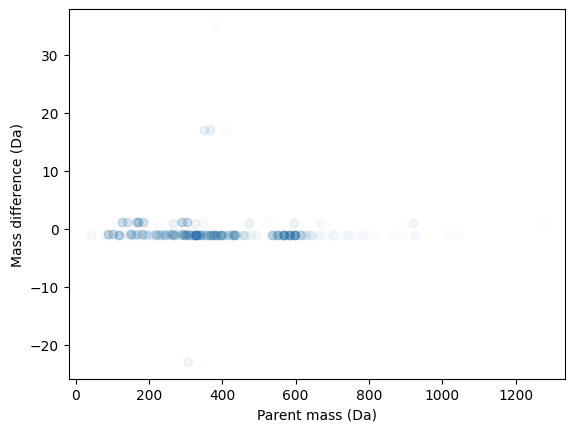

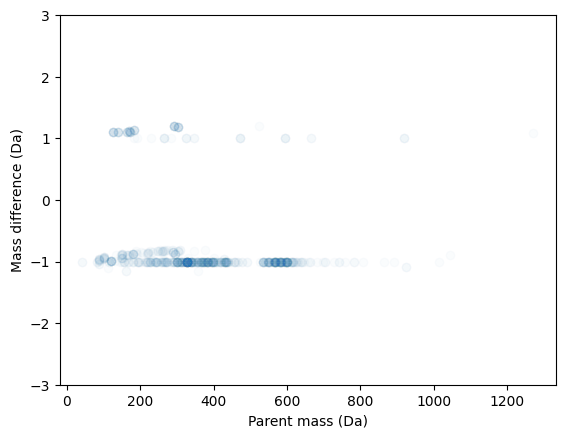

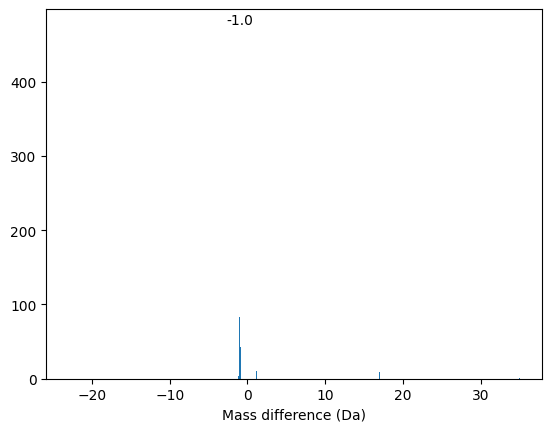

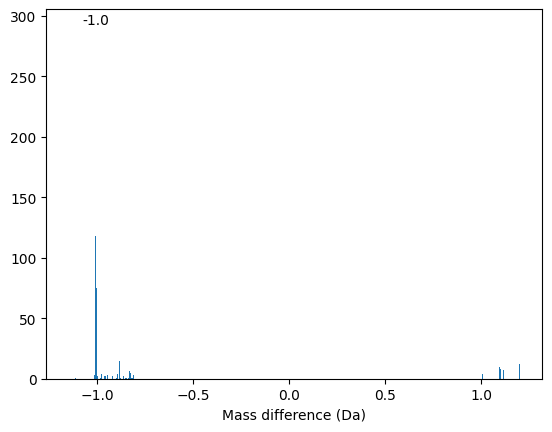

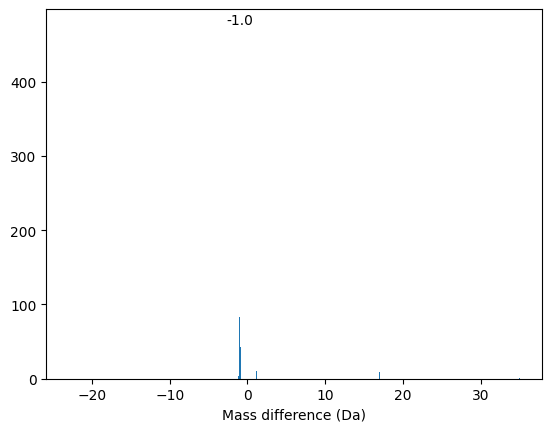

In [57]:
from matchms.filtering.repair_parent_mass_from_smiles.repair_precursor_is_parent_mass import repair_precursor_is_parent_mass

not_repaired, repaired = repair_spectra(not_repaired, mass_tolerance,
                                        "precursor_is_parent_mass",
                                        repair_precursor_is_parent_mass)
plot_all(not_repaired)
plot_all(repaired)

  0%|          | 0/24773 [00:00<?, ?it/s]

  0%|          | 0/23192 [00:00<?, ?it/s]

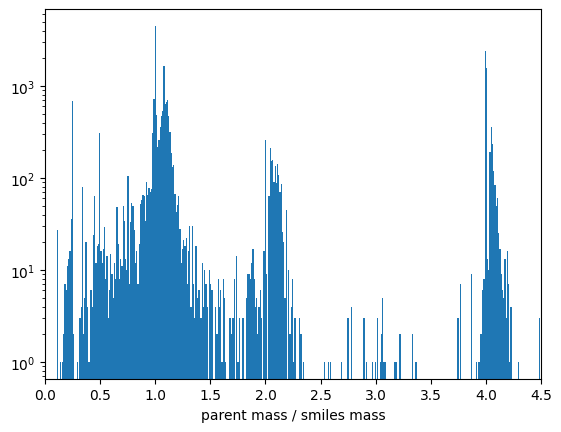

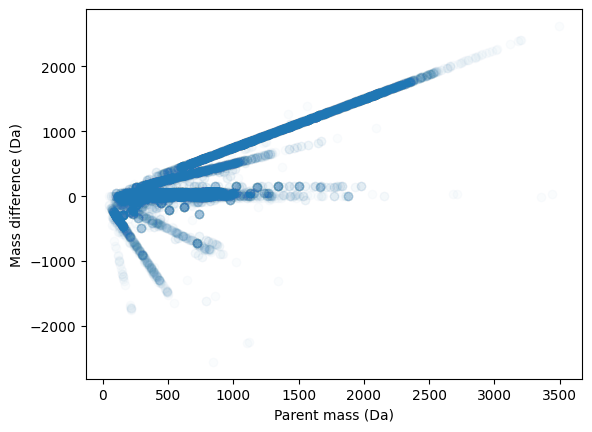

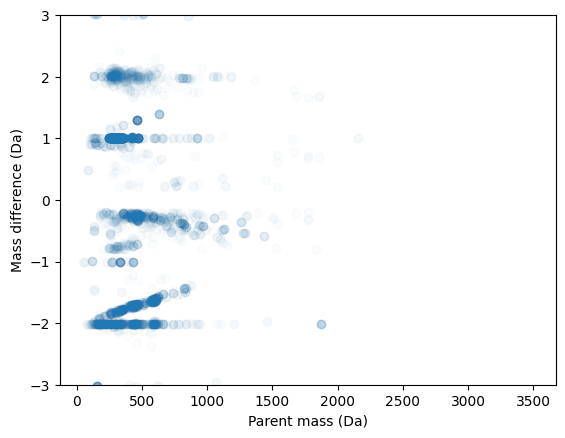

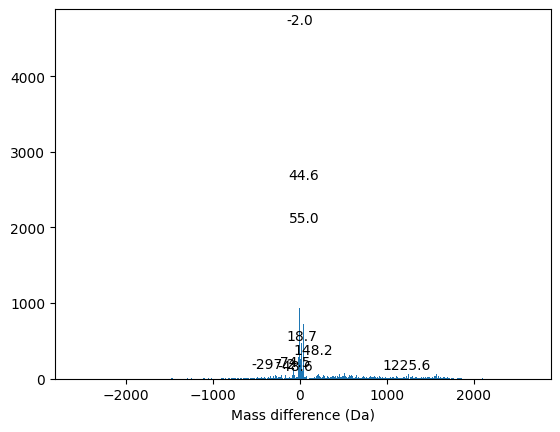

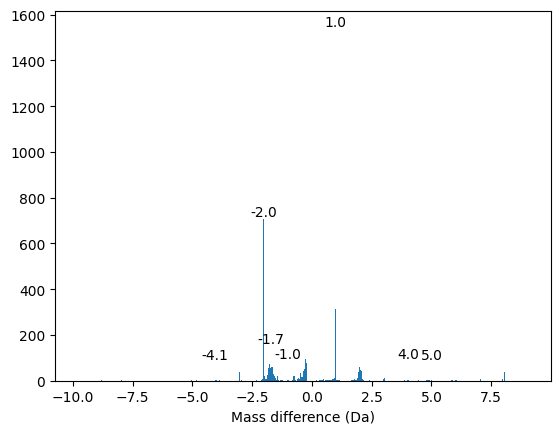

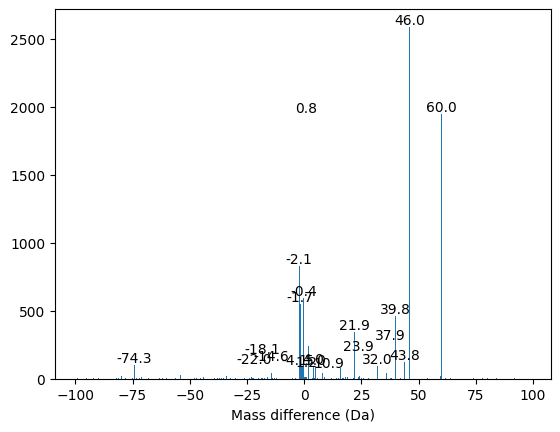

  0%|          | 0/1581 [00:00<?, ?it/s]

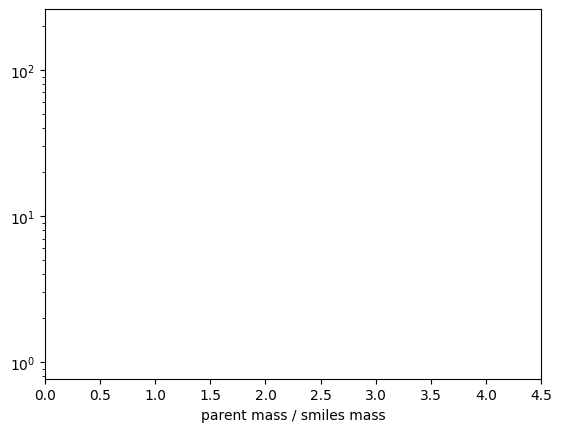

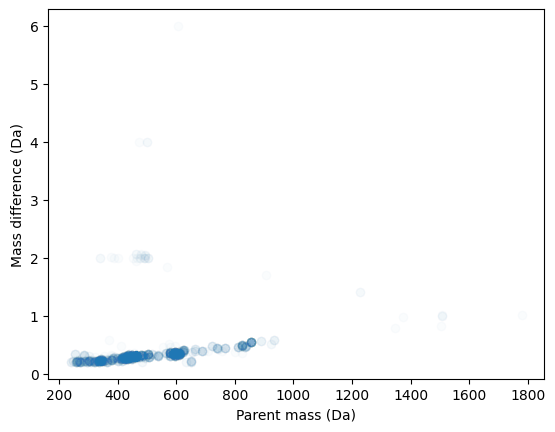

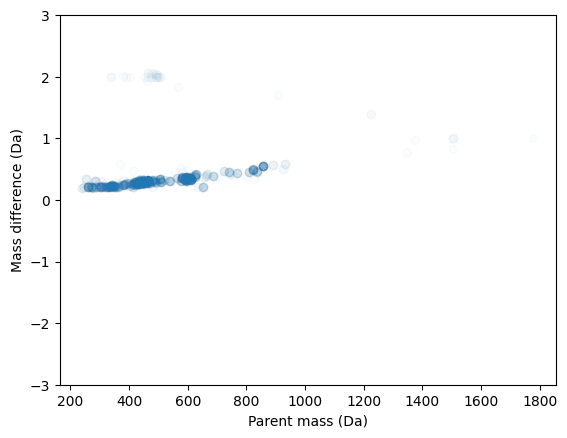

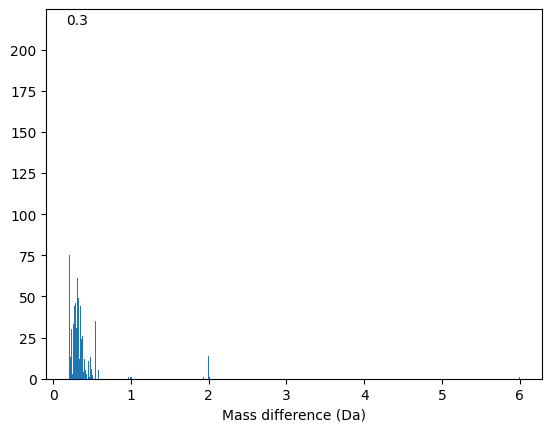

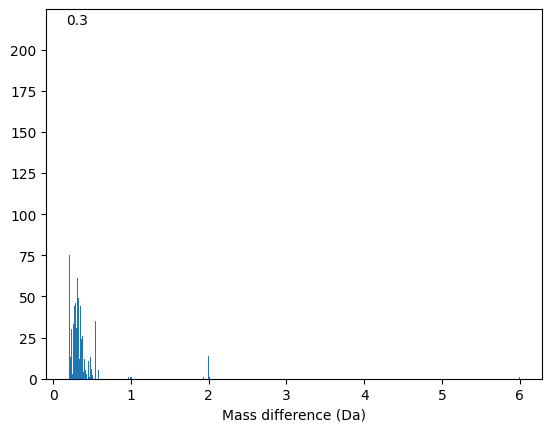

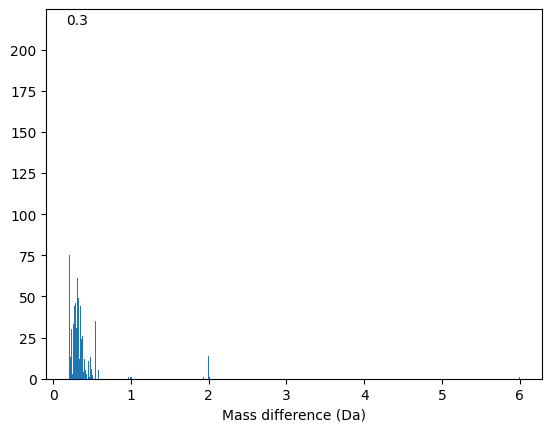

In [58]:
from matchms.filtering.repair_parent_mass_from_smiles.repair_parent_mass_is_mol_wt import repair_parent_mass_is_mol_wt
mass_tolerance = 0.2
not_repaired, repaired = repair_spectra(not_repaired, mass_tolerance,
                                        "parent_mass_is_mol_wt", repair_parent_mass_is_mol_wt)

plot_all(not_repaired)
plot_all(repaired)

  0%|          | 0/23192 [00:00<?, ?it/s]

2023-06-19 13:07:05,564:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 13:07:05,585:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 13:07:05,944:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 13:07:05,947:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 13:07:05,955:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 13:07:05,958:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 13:07:05,960:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 13:07:05,965:WARNING:matchms:repair_adduct_based_on

  0%|          | 0/8113 [00:00<?, ?it/s]

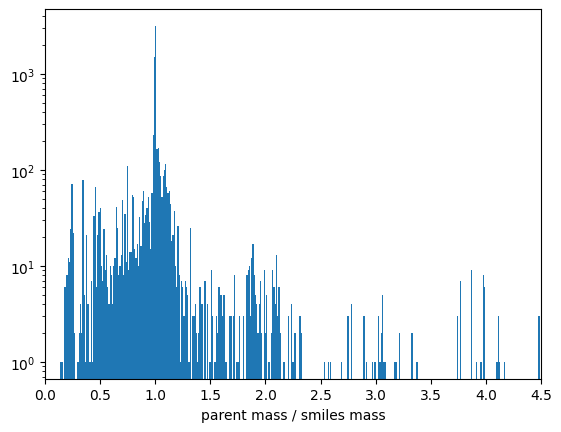

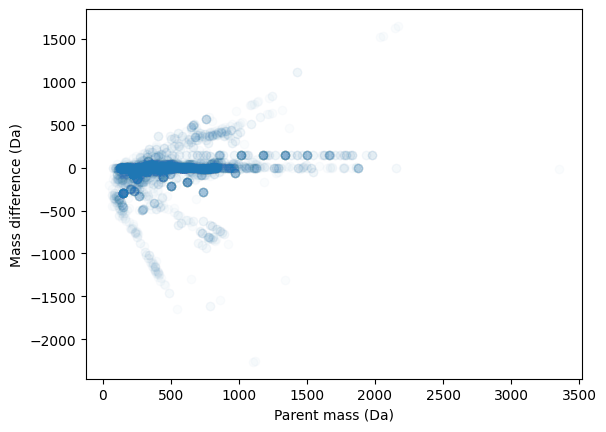

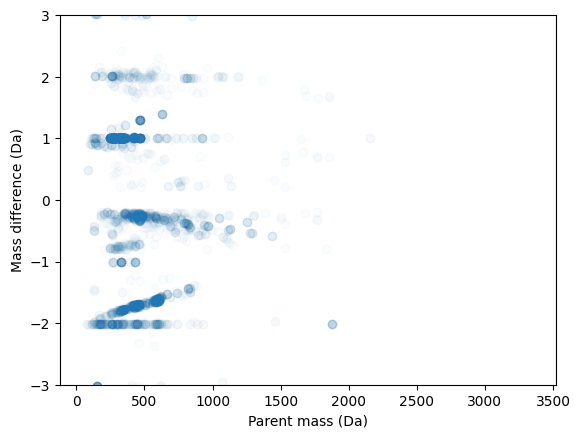

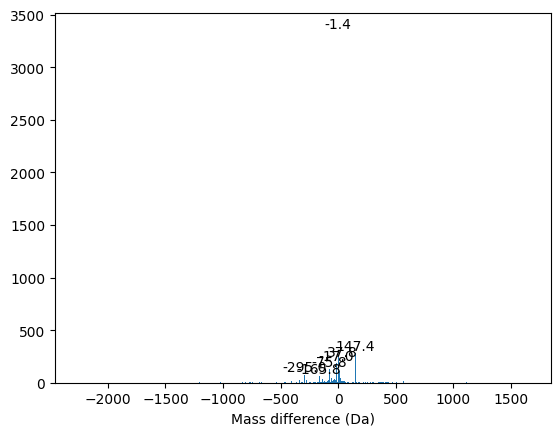

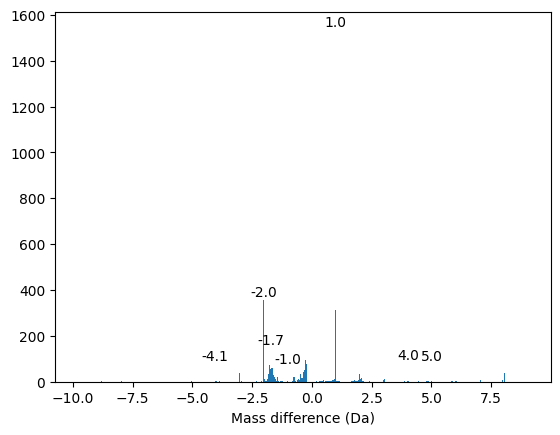

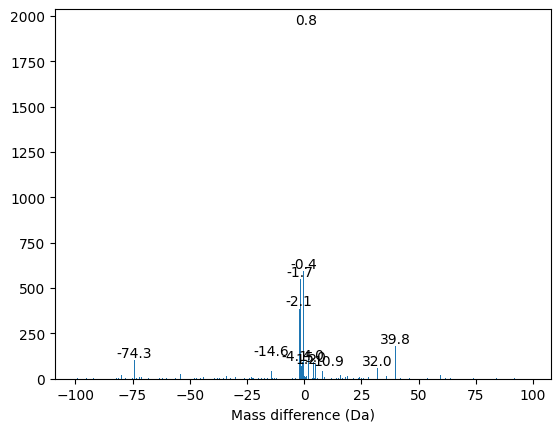

  0%|          | 0/15079 [00:00<?, ?it/s]

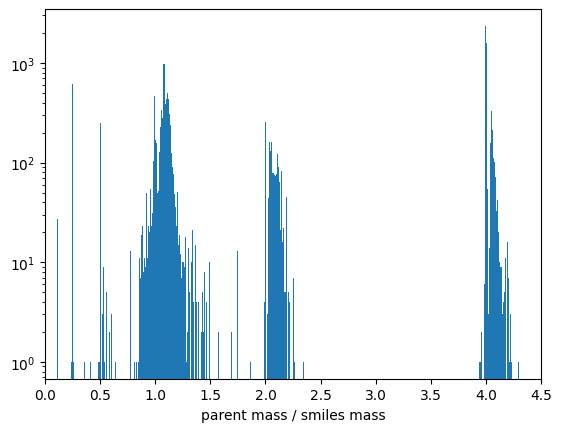

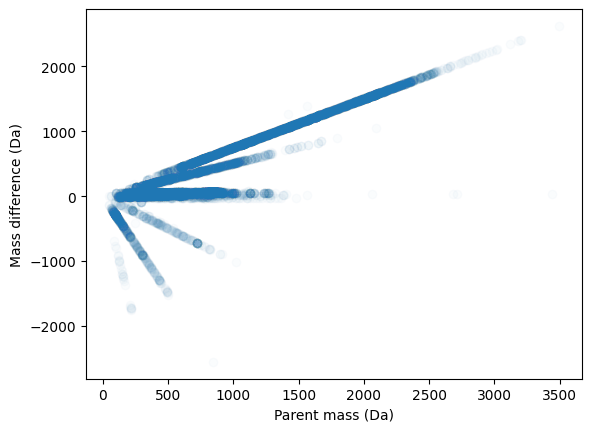

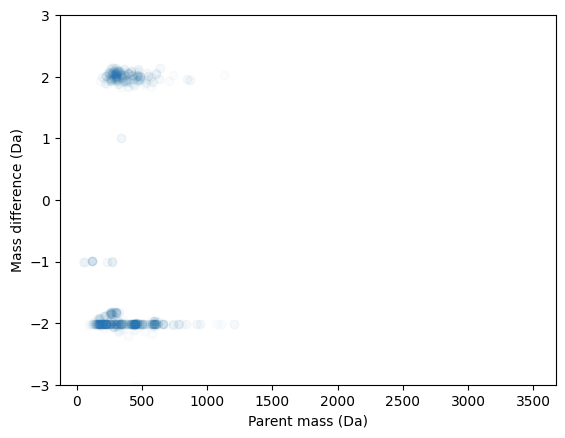

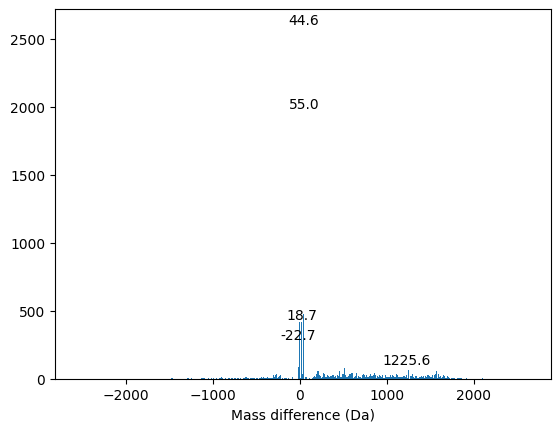

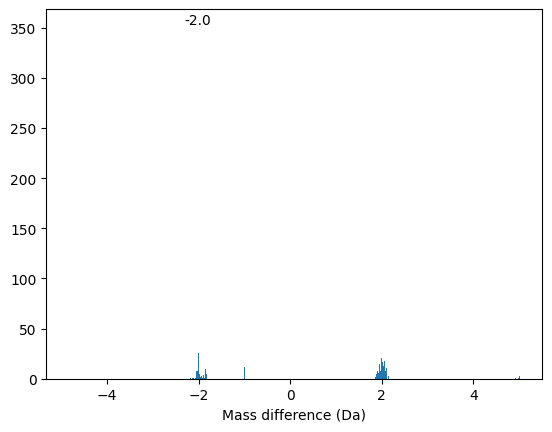

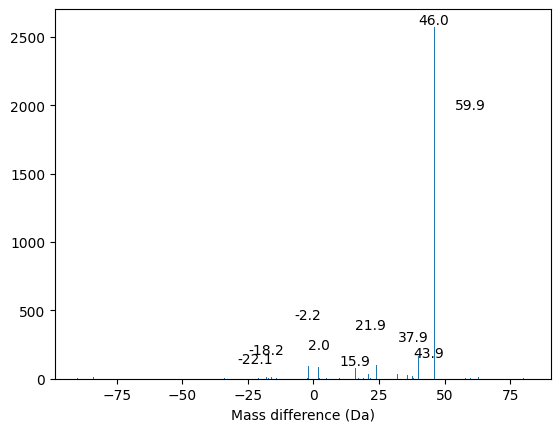

In [59]:
from matchms.filtering.repair_adduct.repair_adduct_based_on_smiles import repair_adduct_based_on_smiles
mass_tolerance = 0.2
not_repaired, repaired = repair_spectra(not_repaired, mass_tolerance,
                                        "adduct_on_smiles", repair_adduct_based_on_smiles,
                                        accept_parent_mass_is_mol_wt=False)
plot_all(not_repaired)
plot_all(repaired)


  0%|          | 0/8113 [00:00<?, ?it/s]

2023-06-19 13:11:36,396:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 13:11:36,418:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 13:11:36,732:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 13:11:36,734:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 13:11:36,743:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 13:11:36,745:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 13:11:36,748:WARNING:matchms:repair_adduct_based_on_smiles:Ionmode: n/a not positive or negative, first run derive_ionmode
2023-06-19 13:11:36,753:WARNING:matchms:repair_adduct_based_on

  0%|          | 0/7254 [00:00<?, ?it/s]

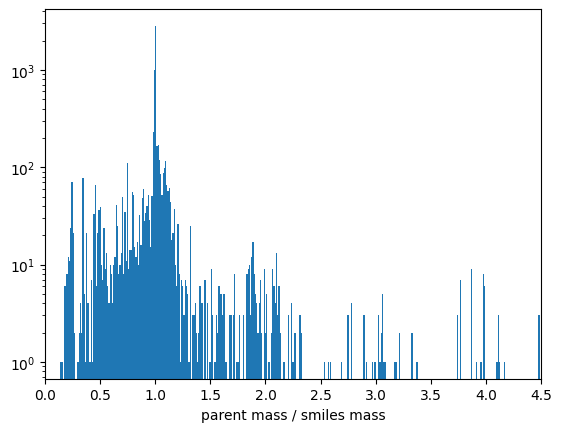

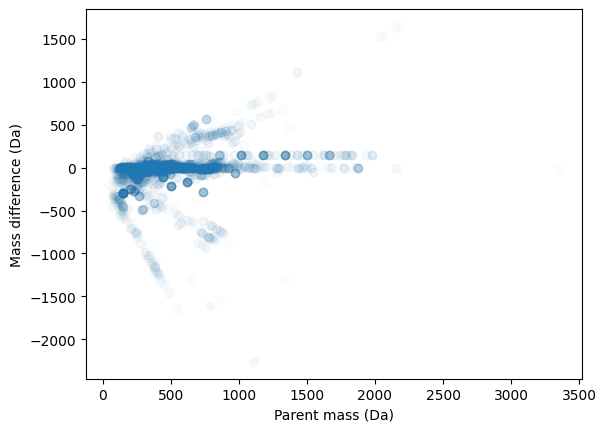

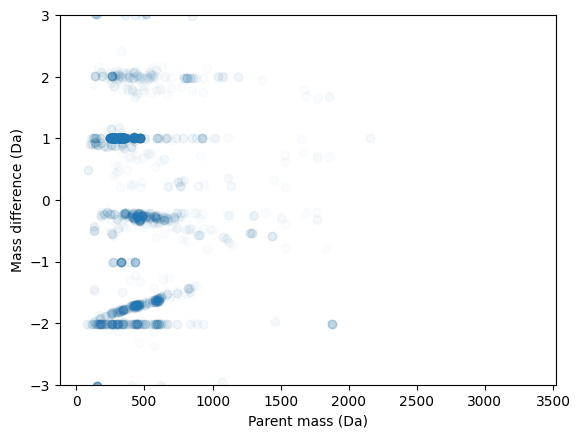

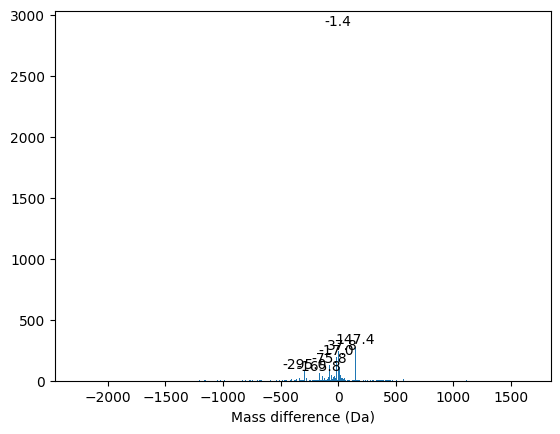

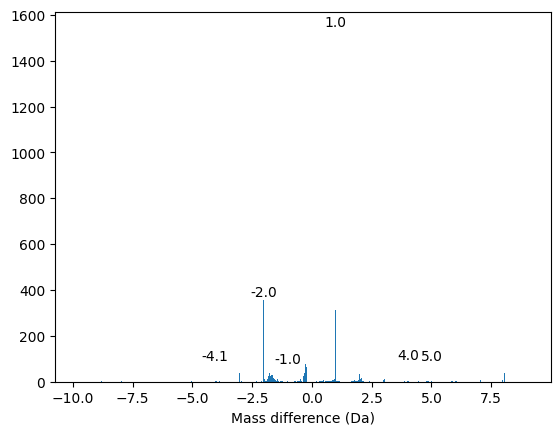

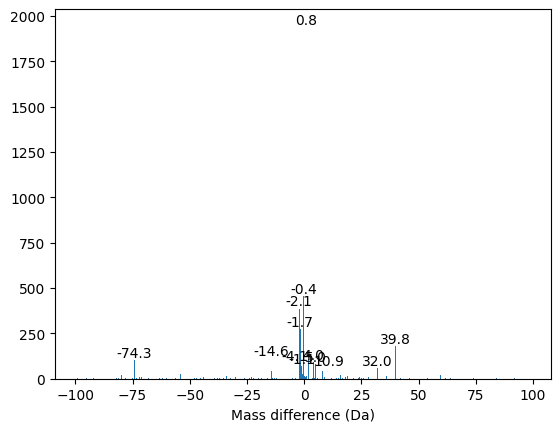

  0%|          | 0/859 [00:00<?, ?it/s]

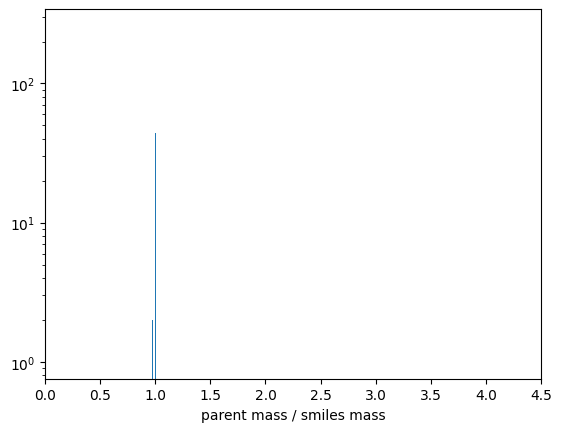

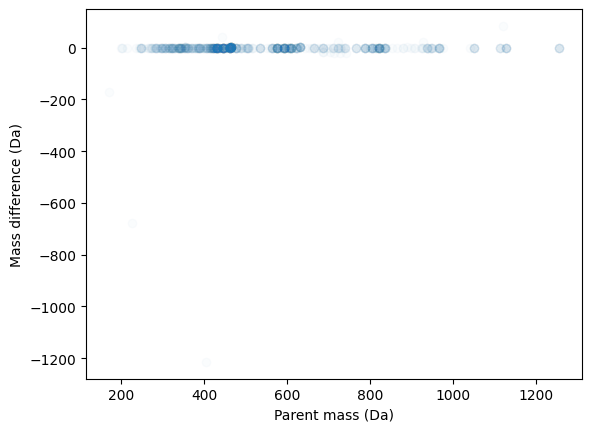

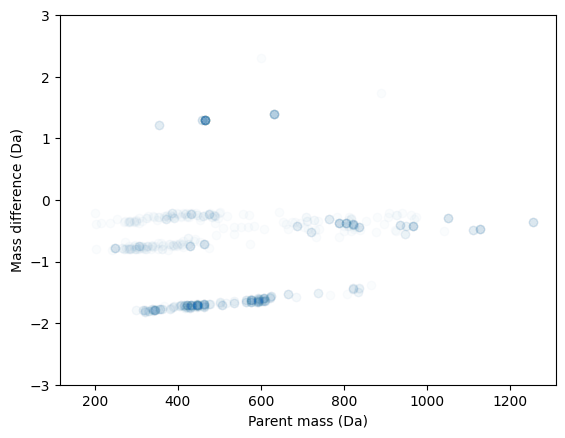

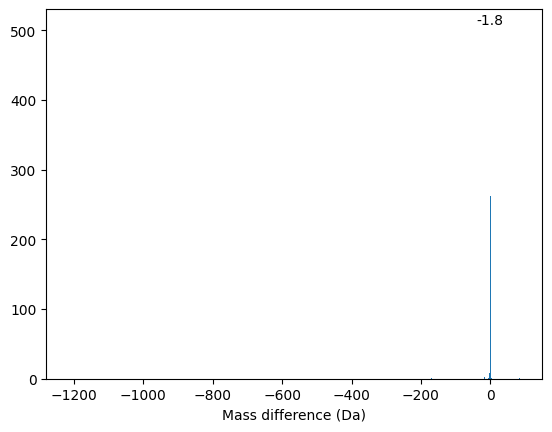

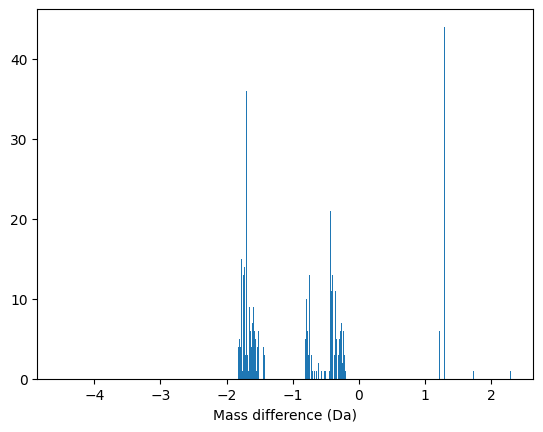

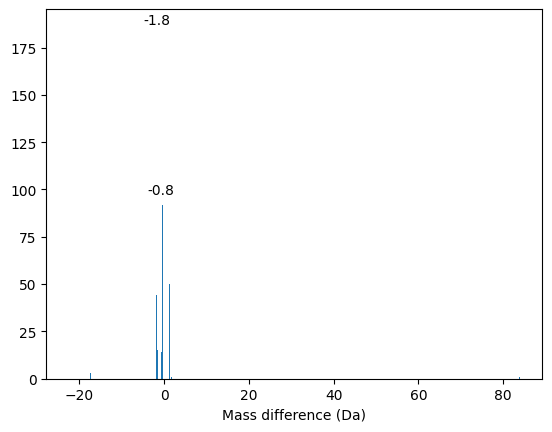

In [60]:
from matchms.filtering.repair_adduct.repair_adduct_based_on_smiles import repair_adduct_based_on_smiles

not_repaired, repaired = repair_spectra(not_repaired, mass_tolerance,
                                        "adduct_on_smiles_accept_pm_is_mol_wt", repair_adduct_based_on_smiles,
                                        accept_parent_mass_is_mol_wt=True)
plot_all(not_repaired)
plot_all(repaired)

In [8]:
def select_mass_differences(spectra):
    mass_differences = []
    parent_masses = []
    expected_masses = []
    for spectrum in tqdm(spectra):
        expected_mass = _get_monoisotopic_neutral_mass(spectrum.get("smiles"))
        parent_mass = spectrum.get("parent_mass")
        mass_difference = parent_mass-expected_mass

        mass_differences.append(mass_difference)
        parent_masses.append(parent_mass)
        expected_masses.append(expected_mass)

    return mass_differences, parent_masses, expected_masses

mass_differences, parent_masses, expected_masses = select_mass_differences(not_repaired)

  0%|          | 0/22038 [00:00<?, ?it/s]

[11:29:08] WARNING: not removing hydrogen atom without neighbors


In [61]:
from matchms.filtering.repair_adduct.clean_adduct import load_adducts_dict
adducts = []
adducts_dict = load_adducts_dict()

for spectrum in not_repaired:
    adducts.append(spectrum.get("adduct"))

summary = {}
unique_adducts = set(adducts)
for unique_adduct in unique_adducts:
    # if unique_adduct not in adducts_dict:
    summary[unique_adduct] = adducts.count(unique_adduct)

In [62]:
sorted_dict = dict(sorted(summary.items(), key=lambda x: x[1], reverse=True))
print(sorted_dict)

{'[M+H]+': 4018, '[M+Na]+': 1139, '[M-H]-': 824, None: 303, '[M-H1]': 223, '[M+CH3COO]-/[M-CH3]-': 220, '[M+2H]2+': 141, '[M-H+CH3OH]': 57, '[M+NH4]+': 39, '[M+H+Na]2+': 37, '[M+K]+': 29, '[2M+Ca]2+': 26, '[M+CH3COO]-': 19, '[M-3H2O+H]+': 13, '[M-H2O+H]+': 12, '[M+Cl]-': 12, '[2M+H]+': 8, '[3M+Ca]2+': 7, '[2M-H]-': 7, '[M+H-3H2O]': 7, '[3M+Na]+': 7, '[M]+': 7, '[2M-H2O+H]+': 6, '[M+15]+': 6, '[M-H+Cl]': 5, '[M+H+HCOOH]': 5, '[4M+Ca]2+': 5, '[2M-2H2O+H]+': 5, '[M-4H2O+H]+': 4, '[M-3H2O+H]': 4, '[2M+Na]+': 3, '[2M-2H+K]': 3, '[M+Li]+': 3, '[M+MeOH-H]': 3, '[M-CO+H]': 3, '[M-C3H7O2]-': 3, '[M-2H2O+H]+': 2, '[M-1]-': 2, '[M-2H]': 2, '[M-C3H7O2]': 2, '[M-H+Li]+': 2, '[2M-H+2Na]+': 2, '[M-5H2O+H]+': 2, '[M+H-(C12H20O9)]+': 2, '[M-H+Na]+': 2, '[M-C2H3O]-': 2, '[M+CH3OH+H]': 1, '[2M+K-2H]': 1, '[M-2H2O+2H]2+': 1, '[M-H2+H]': 1, '[M-3H2O+2H]2+': 1, '[3M+Ca-H]+': 1, '[M-2H2O+NH4]+': 1, '[M+H-99]': 1, '[M-C3H8O+H]': 1, '[3M+NH4]+': 1, '[M-C2H3O]': 1, '[3M+Na]': 1, '[M-C6H10O5+H]': 1, '[M+2Na]': 1

In [16]:
from matchms.filtering.repair_adduct.clean_adduct import clean_adduct
print(clean_adduct('[M-H1]'))

[M-H]-


In [28]:
print(len(not_repaired))

22038


  0%|          | 0/5811 [00:00<?, ?it/s]

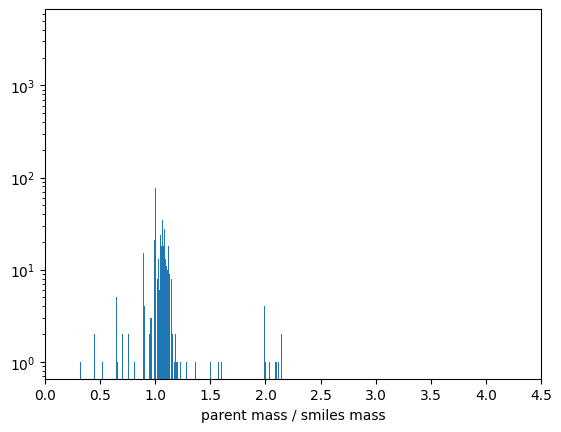

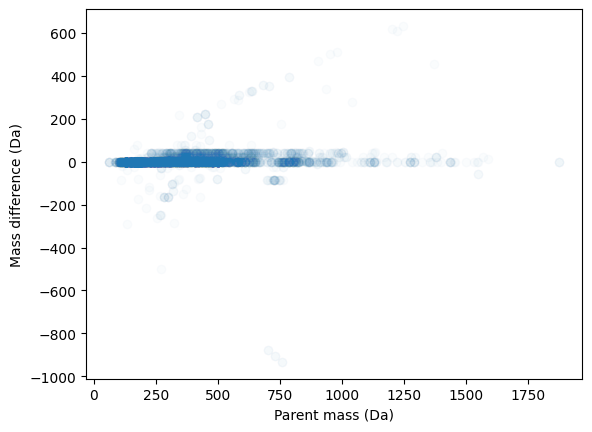

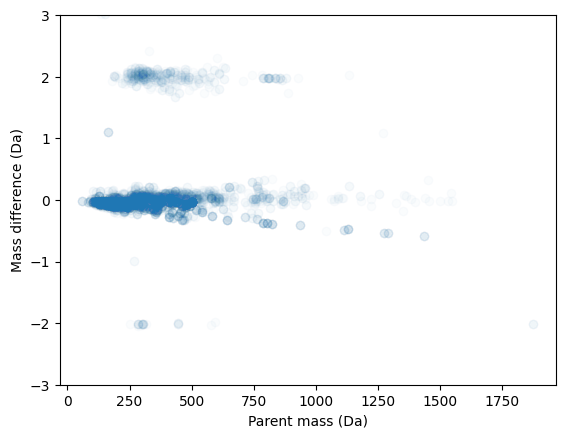

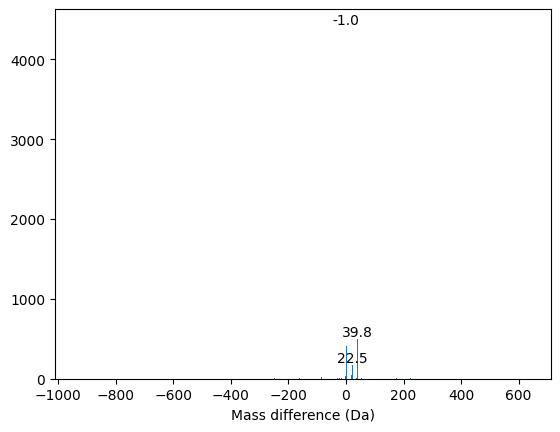

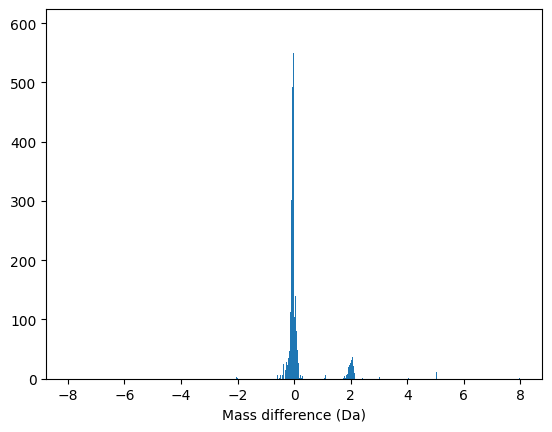

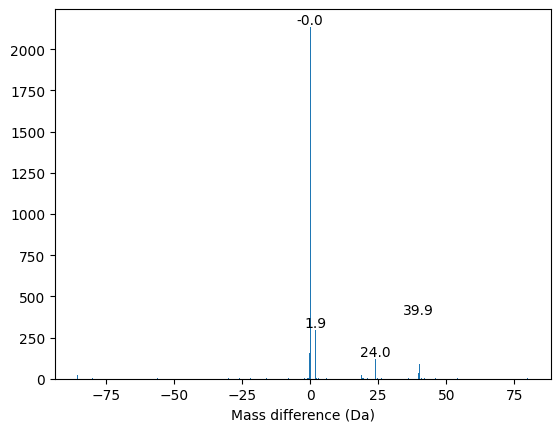

In [41]:
selected_spectra = []
for spectrum in not_repaired:
    if spectrum.get("adduct") == '[M-H]-':
        selected_spectra.append(spectrum)
plot_all(selected_spectra)

3.328164091999838
3.316863963999822
-45.98979223199967
-61.98379223199959
2.9933150320021014
2.9650134080006865
4.057602560000078
3.000908640001853
503.9882108720001
430.76821928800007
173.48847670799998
0.002919172000929393
-13.981168615999195
91.96318132000056
3.018146811999941
3.019091436000508
886.576146812
971.6273829679999
665.3091950158015
3.0183688038021046
1049.5963103999002
1134.6435465558015
1281.7151326478017
3.0183688038014225
3.021068675801871
3.0168411158010713
3.017418611801986
3.019418611801939
3.017540987802249
3.025890923802308
3.0180132998023055
3.0187131718023466
1111.6006603359006
3.017118231801419
-93.97312360000001
-95.9510235360002
-95.95175196800017
-189.96045475999995
-190.0119270360001
-95.95112754800027
-33.96176218000005
-113.99463489599992
-33.96047555599995
-132.00528340800008
-33.96171749999991
-33.960253783999974
-69.93824003999998
-69.98158508799992
-33.96012562000004
-113.99611931599986
-33.96057510399993
-93.97298470799984
-230.00621591999976
-69.93

  0%|          | 0/141 [00:00<?, ?it/s]

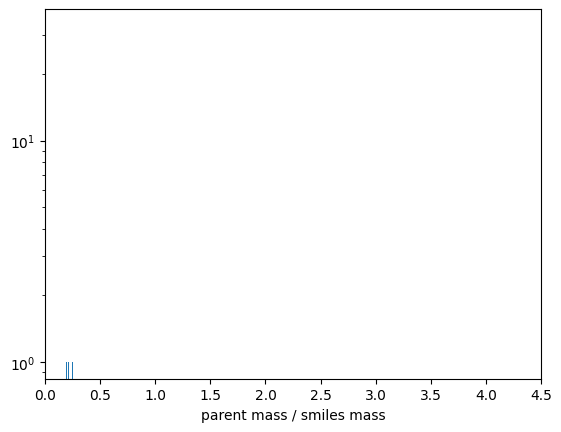

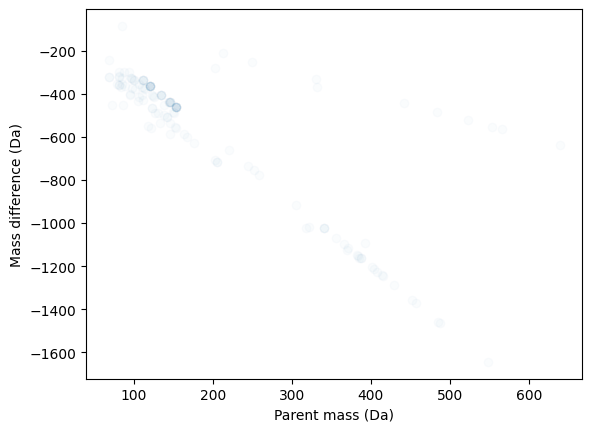

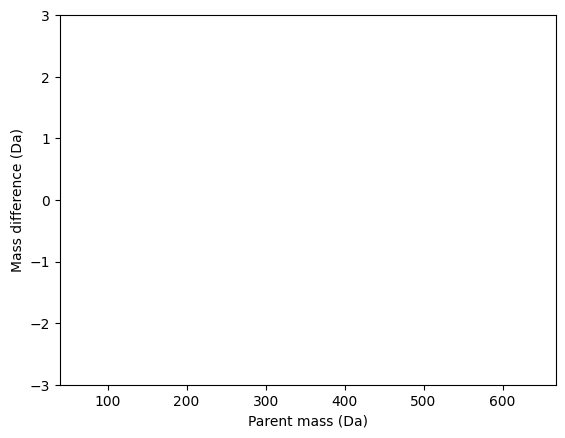

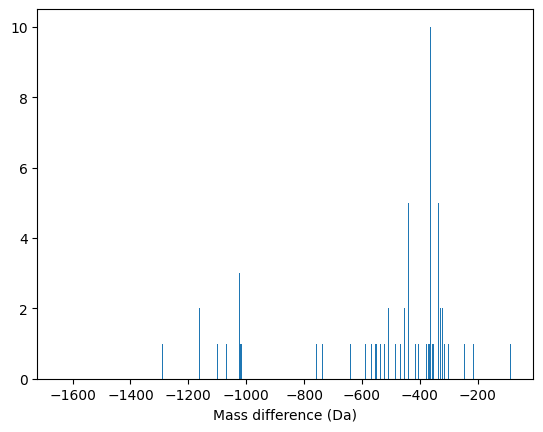

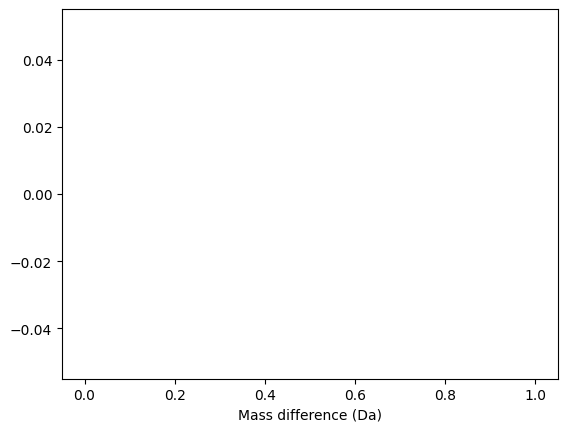

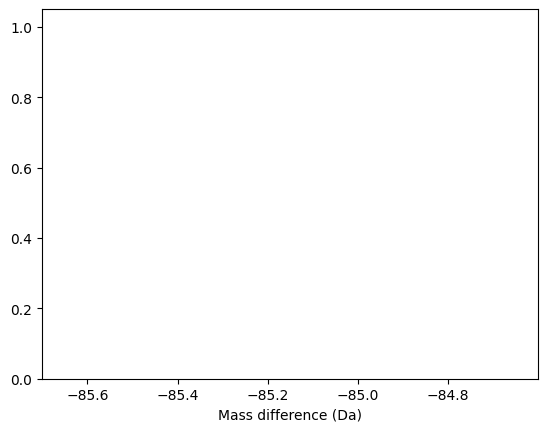

In [86]:
selected_spectra = []
for spectrum in not_repaired:
    if spectrum.get("adduct") == '[M+2H]2+':
        selected_spectra.append(spectrum)
        # print(spectrum.get("parent_mass"))
        print(spectrum.get("precursor_mz")*2 -_get_monoisotopic_neutral_mass(spectrum.get("smiles")))
plot_all(selected_spectra)

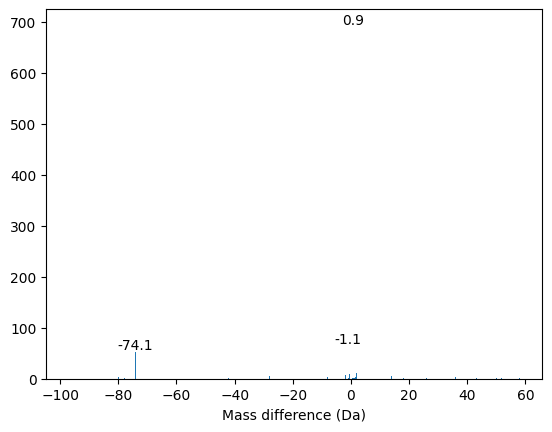

Dorrestein
Koenig/Cruesemann
Koenig/Cruesemann
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP
BMDMS-NP

  0%|          | 0/1139 [00:00<?, ?it/s]

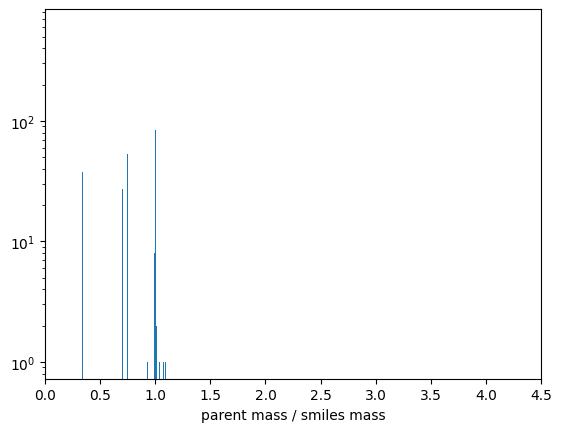

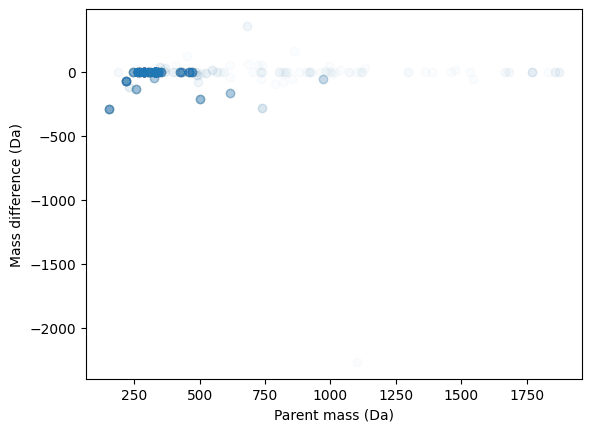

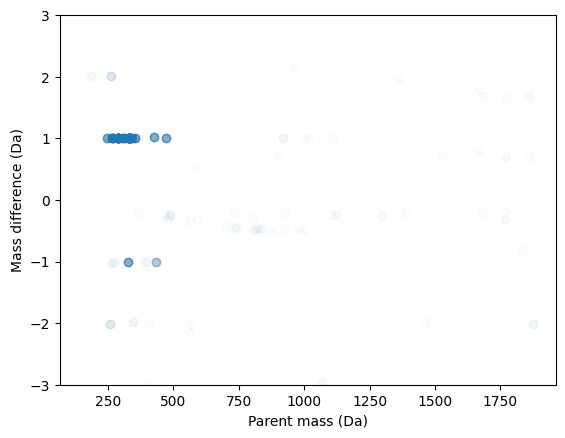

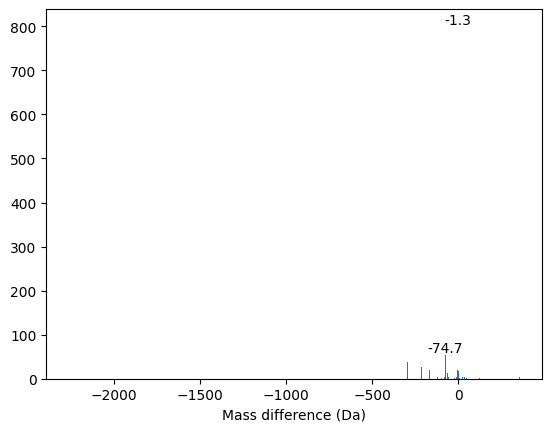

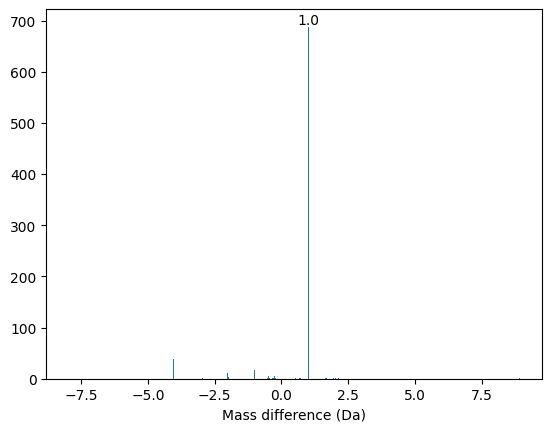

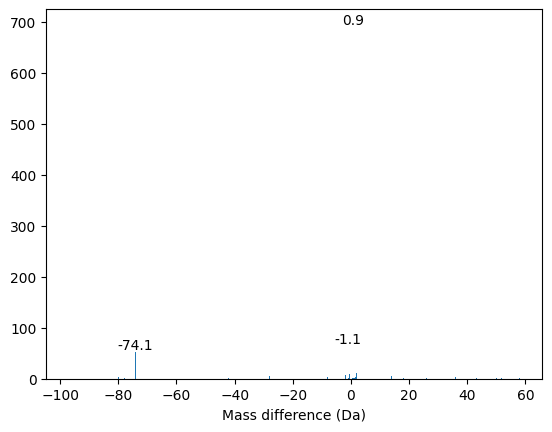

In [77]:
selected_spectra = []
for spectrum in not_repaired:
    if spectrum.get("adduct") =='[M+Na]+':
        selected_spectra.append(spectrum)
        mass_diff = spectrum.get("parent_mass") - _get_monoisotopic_neutral_mass(spectrum.get("smiles"))
        if 0.99< mass_diff < 1.1:
            # print(mass_diff)
            # print(spectrum.get("precursor_mz"))
            # print(spectrum.get("parent_mass"))
            print(spectrum.get("principal_investigator"))
            # print(_get_monoisotopic_neutral_mass(spectrum.get("smiles")))
            # print()

plot_all(selected_spectra)
